## Preliminary Steps

### Import the necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from mixed_naive_bayes import MixedNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib.ticker import FuncFormatter

### Import the Fraud Detection dataset

In [2]:
with zipfile.ZipFile('fraud_detection.zip') as z1:
    with z1.open('Fraud_Data.csv') as Fraud_Data:
        fraud_data = pd.read_csv(Fraud_Data)
    with z1.open('IpAddress_to_Country.csv') as IpAddress_to_Country:
        ip_table = pd.read_csv(IpAddress_to_Country)

## Exploratory Data Analysis

### Explore the Fraud data

In [3]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [4]:
# The proportion of fraud in this dataset (as measured by the 'class' column) is 9.36%

fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [5]:
# Only user_id and signup_time have all unique values

fraud_data.nunique().sort_values()

sex                    2
class                  2
source                 3
browser                5
age                   58
purchase_value       122
device_id         137956
ip_address        143512
purchase_time     150679
user_id           151112
signup_time       151112
dtype: int64

In [6]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
numerical_features = list(fraud_data.select_dtypes('number'))
categorical_features = list(fraud_data.select_dtypes('object'))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Numerical Columns: \n{categorical_features}')

Numerical Columns: 
['user_id', 'purchase_value', 'age', 'ip_address', 'class']

Numerical Columns: 
['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex']


In [8]:
# Each row in the fraud dataset has a unique user_id

# fraud_data.user_id.value_counts()

In [9]:
# fraud_data.signup_time.value_counts()

In [10]:
# fraud_data.purchase_time.value_counts()

In [11]:
# fraud_data.purchase_value.value_counts()

In [12]:
# fraud_data.device_id.value_counts()

In [13]:
# fraud_data.source.value_counts()

In [14]:
# fraud_data.browser.value_counts()

In [15]:
# fraud_data.sex.value_counts()

In [16]:
# fraud_data.age.value_counts()

In [17]:
# fraud_data.ip_address.value_counts()

In [18]:
# fraud_data['class'].value_counts()

### Explore the IP Table data

In [19]:
ip_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [20]:
ip_table.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [21]:
ip_table.nunique().sort_values()

country                      235
lower_bound_ip_address    138846
upper_bound_ip_address    138846
dtype: int64

In [22]:
ip_table.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [23]:
# ip_table.lower_bound_ip_address.value_counts()

In [24]:
# ip_table.upper_bound_ip_address.value_counts()

In [25]:
# ip_table.country.value_counts()

## Feature Engineering

### Get the country related to each IP address

In [26]:
ip_table.upper_bound_ip_address.astype('float')
ip_table.lower_bound_ip_address.astype('float')
fraud_data.ip_address.astype('float')

0         7.327584e+08
1         3.503114e+08
2         2.621474e+09
3         3.840542e+09
4         4.155831e+08
              ...     
151107    3.451155e+09
151108    2.439047e+09
151109    2.748471e+09
151110    3.601175e+09
151111    4.103825e+09
Name: ip_address, Length: 151112, dtype: float64

In [27]:
# Create a function ip_to_country that takes an IP address as argument and returns the country associated based on the IP table

# Create a function normalize_company_names to clean records in the Make column

def ip_to_country(ip):
    '''Takes in an IP address, checks against the lower and upper bound ip address for each country in the IP table
        If the IP address falls within the range of a country, country name is returned.
        If the IP address does not fall within the range of any country, 'Unknown' is returned.
    '''
    try :
        return ip_table.country[(ip_table.lower_bound_ip_address < ip) & (ip_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return 'Unknown'   

### Add a country column related to each IP address

In [28]:
# Create a country column and find the country for each ip address using the ip_to_country function I created]:
fraud_data['country'] = fraud_data.ip_address.apply(ip_to_country)

In [29]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [30]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [31]:
# fraud_data.country.value_counts()

### Add a Relevant Country column that categorizes countries that appear less than 500 times in that dataset as unknown values

In [32]:
min_count = 500
## 29 countries, including unknown are relevant
# fraud_data['country'].value_counts()[lambda x: x >= min_count] 
## 122 countries appear less than 500 times and will be classified as unknown
# fraud_data['country'].value_counts()[lambda x: x < min_count] 

low_count_countries = fraud_data['country'].value_counts()[lambda x: x < min_count].index
low_count_countries

fraud_data['relevant_country'] = fraud_data['country']
fraud_data.loc[fraud_data['country'].isin(low_count_countries), 'relevant_country'] = 'Unknown'

In [33]:
## 29 countries, including unknown are relevant
# fraud_data.relevant_country.value_counts() 

### Add a Countries from Device column that shows the count of countries in which a device made purchases

In [34]:
# Create a dataframe that counts the occurrence of each country by device ID 
country_count = fraud_data.groupby(['device_id','country'])['user_id'].count().reset_index()

# Count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby('device_id').count().country)

# Merge the resulting country_count dataframe with the main fraud_data dataset 
fraud_data = fraud_data.merge(country_count, left_on='device_id', right_index=True)
fraud_data.rename(columns={'country_x': 'country' , 'country_y':'countries_from_device'}, inplace = True)


In [35]:
# fraud_data.countries_from_device.value_counts()

### Add an IP Addresses from Device column that shows the count of IP addresses used by a device purchases

In [36]:
# Create a dataframe that counts the occurrence of each IP address by device ID 
ip_address_count = fraud_data.groupby(['device_id','ip_address'])['user_id'].count().reset_index()

# Count the number of different IP addresses by device_id
ip_address_count = pd.DataFrame(ip_address_count.groupby('device_id').count().ip_address)

# Merge the resulting ip_address_count dataframe with the main fraud_data dataset 
fraud_data = fraud_data.merge(ip_address_count, left_on='device_id', right_index=True)
fraud_data.rename(columns={'ip_address_x': 'ip_address' , 'ip_address_y':'ip_addresses_from_device'}, inplace = True)

In [37]:
# fraud_data.ip_addresses_from_device.value_counts()

### Add an Age Group column that indicates the age range of the purchaser

In [38]:
fraud_data['age_group'] = fraud_data.age.apply(lambda x : 
                 '< 40' if x < 40 else
                 '40 - 49' if x < 50 else
                 '50 - 59' if x < 60 else
                 '60 - 69' if x < 70 else
                 ' > 70')

In [39]:
# fraud_data.age_group.value_counts()

### Add a device frequency column related to the count of each device ID

In [40]:
fraud_data.groupby('device_id').device_id.count().sort_values(ascending=False)

device_id
KIPFSCNUGOLDP    20
NGQCKIADMZORL    20
CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
EQYVNEGOFLAWK    20
                 ..
IXVBQLPWSAIDA     1
IXUYCZZVDXGPO     1
IXUWTGATQJEVG     1
IXUKDXQBVCYCZ     1
ZZZXASJUVUNMV     1
Name: device_id, Length: 137956, dtype: int64

In [41]:
device_freq = pd.DataFrame(fraud_data.groupby('device_id').device_id.count())

# Rename the count of device_id to device_freq so there is no duplicate column name
device_freq.rename(columns={'device_id': 'device_freq'}, inplace=True)

# Convert device_id from index to column so we can merge with the fraud_data dataset
device_freq.reset_index(level=0, inplace= True)

# Merge device_freq dataset with the fraud_data dataset
fraud_data = fraud_data.merge(device_freq, on= 'device_id')


In [42]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,relevant_country,countries_from_device,ip_addresses_from_device,age_group,device_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan,1,1,< 40,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States,1,1,50 - 59,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12


In [43]:
# fraud_data.device_freq.value_counts()

Text(0, 0.5, 'Distribution')

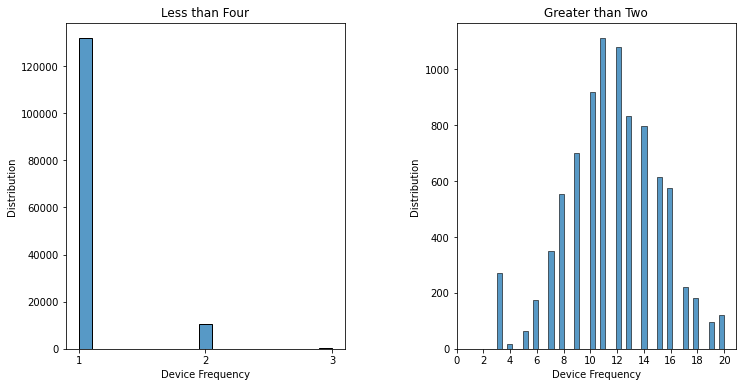

In [44]:
f, ax = plt.subplots(1,2,figsize=(12,6))
f.subplots_adjust(wspace=0.4)
g1 =sns.histplot(fraud_data.device_freq[fraud_data.device_freq <4], ax=ax[0])
g1.set(xticks=[1,2,3])
ax[0].set_title('Less than Four')
ax[0].set_xlabel('Device Frequency')
ax[0].set_ylabel('Distribution')

g2 =sns.histplot(fraud_data.device_freq[fraud_data.device_freq >2], ax=ax[1])
g2.set(xticks = range(0,21,2))
ax[1].set_title('Greater than Two')
ax[1].set_xlabel('Device Frequency')
ax[1].set_ylabel('Distribution')


### Add an IP address frequency column related to the count of each IP address

In [45]:
fraud_data.groupby('ip_address').ip_address.count().sort_values(ascending=False)

ip_address
1.502818e+09    20
5.760609e+08    20
3.874758e+09    20
2.050964e+09    20
2.937899e+09    19
                ..
1.427304e+09     1
1.427303e+09     1
1.427285e+09     1
1.427208e+09     1
4.294850e+09     1
Name: ip_address, Length: 143512, dtype: int64

In [46]:
ip_address_freq = pd.DataFrame(fraud_data.groupby('ip_address').ip_address.count())

# Rename the count of ip_address to ip_address_freq so there is no duplicate column name
ip_address_freq.rename(columns={'ip_address': 'ip_address_freq'}, inplace=True)

# Convert ip_address from index to column so we can merge with the fraud_data dataset
ip_address_freq.reset_index(level=0, inplace= True)

# Merge ip_address_freq dataset with the fraud_data dataset
fraud_data = fraud_data.merge(ip_address_freq, on= 'ip_address')

In [47]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,relevant_country,countries_from_device,ip_addresses_from_device,age_group,device_freq,ip_address_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan,1,1,< 40,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States,1,1,50 - 59,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12


In [48]:
# fraud_data.ip_address_freq.value_counts()

Text(0, 0.5, 'Distribution')

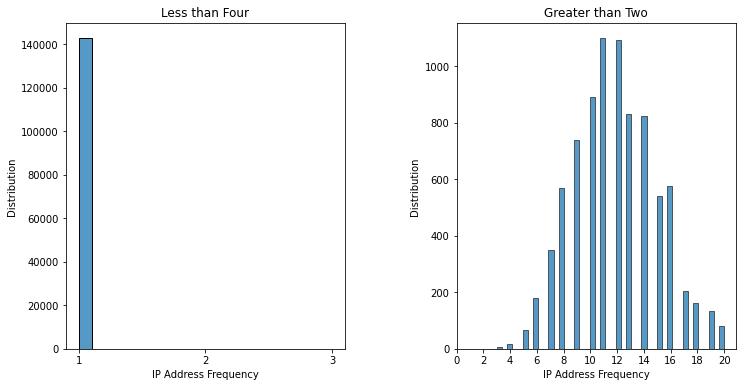

In [49]:
f, ax = plt.subplots(1,2,figsize=(12,6))
f.subplots_adjust(wspace=0.4)
g1 =sns.histplot(fraud_data.ip_address_freq[fraud_data.ip_address_freq <4], ax=ax[0])
g1.set(xticks=[1,2,3])
ax[0].set_title('Less than Four')
ax[0].set_xlabel('IP Address Frequency')
ax[0].set_ylabel('Distribution')

g2 =sns.histplot(fraud_data.ip_address_freq[fraud_data.ip_address_freq >2], ax=ax[1])
g2.set(xticks = range(0,21,2))
ax[1].set_title('Greater than Two')
ax[1].set_xlabel('IP Address Frequency')
ax[1].set_ylabel('Distribution')

In [50]:
# Sometimes the same device uses a different IP address

fraud_data.loc[fraud_data['device_freq'] != fraud_data['ip_address_freq']]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,relevant_country,countries_from_device,ip_addresses_from_device,age_group,device_freq,ip_address_freq
43,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1,United States,United States,2,2,< 40,2,1
44,391381,2015-01-03 21:08:02,2015-02-07 04:18:59,18,WUMOBGUCBOXPO,Direct,Safari,M,36,3.794865e+09,0,Unknown,Unknown,2,2,< 40,2,1
62,262245,2015-01-03 03:29:05,2015-02-26 23:23:55,38,YAQQIDVLQRBLL,Ads,IE,F,21,2.803457e+09,0,United States,United States,1,2,< 40,2,1
63,236962,2015-02-23 13:34:18,2015-05-12 23:55:39,17,YAQQIDVLQRBLL,SEO,Safari,F,24,2.197290e+09,0,United States,United States,1,2,< 40,2,1
75,313833,2015-08-16 20:48:52,2015-11-17 09:43:11,12,GDATAKTYQUGWR,Ads,IE,M,55,5.690384e+08,0,United States,United States,2,2,50 - 59,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148822,294559,2015-07-15 12:06:24,2015-10-27 15:24:16,35,WFVWFMHQFSTTI,SEO,Chrome,F,30,2.606393e+09,0,United States,United States,1,2,< 40,2,1
150158,126823,2015-04-13 16:30:14,2015-07-17 01:20:39,18,VHZDPOJTZTXKT,Direct,IE,F,30,3.459896e+08,0,United States,United States,2,2,< 40,2,1
150159,118840,2015-07-02 22:51:46,2015-10-18 01:17:12,52,VHZDPOJTZTXKT,Direct,Chrome,F,31,1.905206e+09,0,China,China,2,2,< 40,2,1
150692,33093,2015-02-03 12:34:37,2015-05-20 09:13:17,56,WVGTVGWKVRTFO,Ads,IE,F,40,3.594400e+09,0,United States,United States,1,2,40 - 49,2,1


### Add a same_purchase_freq column that groups how many times the same device purchased an item with the same value

In [51]:
#  Create a series that indicates, for each line, if the device_id and purchase_value combination has duplicates
duplicate = fraud_data.duplicated(subset = ['purchase_value','device_id'], keep = False)
# Merge the series with a dataframe containing purchase_value and device_id
duplicate = pd.concat([fraud_data.loc[:,['purchase_value','device_id']], duplicate],axis=1)
# Create a dataframe that shows the number of duplicates for each device_id and purchase_value combination
duplicate = duplicate.groupby(['device_id','purchase_value']).sum()
# Add a same_purchase_freq column that groups the duplicate count of each device_id and purchase_value combination
duplicate['same_purchase_freq'] = duplicate[0].apply(lambda x : 
                                                str(x) if x < 5 else
                                                '5-10' if x<=10 else
                                                '11-15' if x<= 15 else
                                                '>15' 
                                               )
                                            
# Merge the resulting duplicate dataframe with the main fraud_data dataset            
fraud_data = fraud_data.merge(duplicate.drop(0,axis=1), left_on=['device_id','purchase_value'], right_index = True)

In [52]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,relevant_country,countries_from_device,ip_addresses_from_device,age_group,device_freq,ip_address_freq,same_purchase_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan,1,1,< 40,1,1,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States,1,1,50 - 59,1,1,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12,11-15
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12,11-15
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,1,1,50 - 59,12,12,11-15


In [53]:
# fraud_data.same_purchase_freq.value_counts()

### Add columns related to the date and time of day

In [54]:
fraud_data.signup_time = pd.to_datetime(fraud_data.signup_time, format = '%Y-%m-%d %H:%M:%S')
fraud_data.purchase_time = pd.to_datetime(fraud_data.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# Add a 'month of purchase' column
fraud_data['purchase_month'] = fraud_data.purchase_time.apply(lambda x: calendar.month_name[x.month])

# Add a 'week of purchase' column
fraud_data['purchase_weekday'] = fraud_data.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# Add an 'hour of purchase' column
fraud_data['purchase_hour'] = fraud_data.purchase_time.apply(lambda x: x.hour)

# Add a 'seconds since signup'
fraud_data['seconds_since_signup']= (fraud_data.purchase_time - fraud_data.signup_time).apply(lambda x : x.total_seconds())

In [55]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,countries_from_device,ip_addresses_from_device,age_group,device_freq,ip_address_freq,same_purchase_freq,purchase_month,purchase_weekday,purchase_hour,seconds_since_signup
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,1,1,< 40,1,1,0,April,Saturday,2,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,1,50 - 59,1,1,0,June,Monday,1,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,1,50 - 59,12,12,11-15,January,Thursday,18,1.0
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,1,50 - 59,12,12,11-15,January,Thursday,18,1.0
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,1,50 - 59,12,12,11-15,January,Thursday,18,1.0


In [56]:
# fraud_data.purchase_month.value_counts()

In [57]:
# fraud_data.purchase_weekday.value_counts()

In [58]:
# fraud_data.purchase_hour.value_counts()

In [59]:
# fraud_data.seconds_since_signup.value_counts()

In [60]:
fraud_data.describe()

,user_id,signup_time,purchase_time,purchase_value,age,ip_address,class,countries_from_device,ip_addresses_from_device,device_freq,ip_address_freq,purchase_hour,seconds_since_signup
count,151112.000000,151112,151112,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05
mean,200171.040970,2015-04-20 00:56:09.511329280,2015-06-16 02:56:38.759953152,36.935372,33.140704,2.152145e+09,0.093646,1.063489,1.078200,1.684367,1.602719,11.521593,4.932029e+06
min,2.000000,2015-01-01 00:00:42,2015-01-01 00:00:44,9.000000,18.000000,5.209350e+04,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000e+00
25%,100642.500000,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,22.000000,27.000000,1.085934e+09,0.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2.186754e+06
50%,199958.000000,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,35.000000,33.000000,2.154770e+09,0.000000,1.000000,1.000000,1.000000,1.000000,12.000000,4.926346e+06
75%,300054.000000,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,49.000000,39.000000,3.243258e+09,0.000000,1.000000,1.000000,1.000000,1.000000,17.000000,7.644524e+06
max,400000.000000,2015-08-18 04:40:29,2015-12-16 02:56:05,154.000000,76.000000,4.294850e+09,1.000000,4.000000,4.000000,20.000000,20.000000,23.000000,1.036797e+07
std,115369.285024,NaN,NaN,18.322762,8.617733,1.248497e+09,0.291336,0.248146,0.275591,2.616954,2.596240,6.912474,3.126263e+06


In [61]:
# Group by the period of the day at which the purchase was made
fraud_data['purchase_period_of_day'] = fraud_data.purchase_hour.apply(lambda x : 
                                                             'late night' if x < 4 else
                                                             'early morning' if x < 8 else
                                                             'morning' if x < 12 else
                                                             'early afternoon' if x < 16 else
                                                             'afternoon' if x < 20 else
                                                             'evening'
                                                            )

In [62]:
fraud_data.seconds_since_signup.min()

1.0

In [63]:
fraud_data.seconds_since_signup.max()

10367972.0

In [64]:
pd.qcut(fraud_data.seconds_since_signup, q=19)

0         (4062544.421, 4642407.474]
1                 (0.999, 26337.053]
2                 (0.999, 26337.053]
3                 (0.999, 26337.053]
4                 (0.999, 26337.053]
                     ...            
151107    (7498441.211, 8079595.263]
151108    (6933466.368, 7498441.211]
151109       (608744.421, 1201455.0]
151110    (6352782.263, 6933466.368]
151111    (3489097.684, 4062544.421]
Name: seconds_since_signup, Length: 151112, dtype: category
Categories (19, interval[float64, right]): [(0.999, 26337.053] < (26337.053, 608744.421] < (608744.421, 1201455.0] < (1201455.0, 1766604.789] ... (8079595.263, 8647682.737] < (8647682.737, 9218721.211] < (9218721.211, 9788699.0] < (9788699.0, 10367972.0]]

In [65]:
fraud_data['seconds_since_signup_cat'] = pd.qcut(fraud_data.seconds_since_signup, q=19)

In [66]:
fraud_data['seconds_since_signup_cat_str'] = fraud_data['seconds_since_signup_cat'].astype(str)

In [67]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,device_freq,ip_address_freq,same_purchase_freq,purchase_month,purchase_weekday,purchase_hour,seconds_since_signup,purchase_period_of_day,seconds_since_signup_cat,seconds_since_signup_cat_str
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,1,1,0,April,Saturday,2,4506682.0,late night,"(4062544.421, 4642407.474]","(4062544.421, 4642407.474]"
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,1,0,June,Monday,1,17944.0,late night,"(0.999, 26337.053]","(0.999, 26337.053]"
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,12,12,11-15,January,Thursday,18,1.0,afternoon,"(0.999, 26337.053]","(0.999, 26337.053]"
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,12,12,11-15,January,Thursday,18,1.0,afternoon,"(0.999, 26337.053]","(0.999, 26337.053]"
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,12,12,11-15,January,Thursday,18,1.0,afternoon,"(0.999, 26337.053]","(0.999, 26337.053]"


In [68]:
# fraud_data['seconds_since_signup_cat'].value_counts()

In [69]:
def sort_bins(bin_col):
    '''
    Sorts bins after using pd.cut. Increasing order. Puts 'NaN' bin at the beginning. 

    Input:
        bin_col: pd.series containing bins to be sorted

    '''

    # Dictionary to store first value from each bin
    vals = {}

    # Iterate through all bins
    for i, item in enumerate(bin_col.unique()):

        # Check if bin is 'nan', if yes, assign low value to put it at the beginning
        if item == 'nan':
            vals[i] = -99999

        # If not 'nan', get the first value from bin to sort later
        else:
            vals[i] = float(item.split(',')[0][1:])

    # Sort bins according to extracted first values
    ixs = list({k: v for k, v in \
                    sorted(vals.items(), key=lambda item: item[1])}.keys())

    # Make sorted list of bins
    sorted_bins = bin_col.unique()[list(ixs)]

    return sorted_bins

In [70]:
# Example, assuming 'age_bin' column has the bins:
sorted_bins = sort_bins(fraud_data['seconds_since_signup_cat_str'])

In [71]:
sorted_bins

array(['(0.999, 26337.053]', '(26337.053, 608744.421]',
       '(608744.421, 1201455.0]', '(1201455.0, 1766604.789]',
       '(1766604.789, 2329427.421]', '(2329427.421, 2906125.947]',
       '(2906125.947, 3489097.684]', '(3489097.684, 4062544.421]',
       '(4062544.421, 4642407.474]', '(4642407.474, 5208502.632]',
       '(5208502.632, 5781175.0]', '(5781175.0, 6352782.263]',
       '(6352782.263, 6933466.368]', '(6933466.368, 7498441.211]',
       '(7498441.211, 8079595.263]', '(8079595.263, 8647682.737]',
       '(8647682.737, 9218721.211]', '(9218721.211, 9788699.0]',
       '(9788699.0, 10367972.0]'], dtype=object)

In [72]:
fraud_data['quick_purchase'] = fraud_data.seconds_since_signup.apply(lambda x : 1 if x < 137 else 0)

In [73]:
# fraud_data.quick_purchase.value_counts()

In [74]:
fraud_data['first_purchase'] = fraud_data.apply(lambda x : 
                                         1 if x.purchase_time == fraud_data.purchase_time[fraud_data.device_id == x.device_id].min() else 0,
                                         axis =1)

In [75]:
# fraud_data.first_purchase.value_counts()

### Explore Likelihood of Fraud by Category

In [76]:
# fraud_data.groupby('source').head()
fraud_data.groupby('source')['class'].mean()
fraud_data.groupby('source')['class'].mean().index
# .mean()

Index(['Ads', 'Direct', 'SEO'], dtype='object', name='source')

In [77]:
# fraud_data['country'].value_counts()


In [78]:
fraud_data.groupby('country')['class'].mean().sort_values(ascending=False)[:28]

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Ireland                  0.229167
New Zealand              0.223022
Uzbekistan               0.200000
Lithuania                0.189474
Saudi Arabia             0.189394
Malta                    0.181818
Afghanistan              0.166667
Cote D'ivoire            0.166667
Denmark                  0.159184
Chile                    0.153477
Greece                   0.142857
Malawi                   0.142857
Montenegro               0.142857
United Arab Emirates     0.140351
Belgium                  0.136919
Egypt                    0.133705
Armenia                  0.133333
Costa Rica               0.133333
Name: class, dtype: float64

In [79]:
#Filter countries to those with at least 1000 transactions

relevant_countries = fraud_data['country'].value_counts() > 1000
relevant_countries_list = list(relevant_countries[relevant_countries == True].index)
relevant_countries_list



['United States',
 'Unknown',
 'China',
 'Japan',
 'United Kingdom',
 'Korea Republic of',
 'Germany',
 'France',
 'Canada',
 'Brazil',
 'Italy',
 'Australia',
 'Netherlands',
 'Russian Federation',
 'India',
 'Taiwan; Republic of China (ROC)',
 'Mexico',
 'Sweden',
 'Spain']

In [80]:
fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False)[:28]

country
Mexico                             0.128457
Sweden                             0.120183
Canada                             0.116975
India                              0.115267
United Kingdom                     0.106236
Japan                              0.097865
United States                      0.095626
France                             0.094907
Korea Republic of                  0.091302
Brazil                             0.091185
Australia                          0.089479
China                              0.086642
Unknown                            0.085723
Italy                              0.085391
Russian Federation                 0.082921
Taiwan; Republic of China (ROC)    0.080032
Netherlands                        0.073214
Germany                            0.071860
Spain                              0.071081
Name: class, dtype: float64

In [81]:
fraud_data.groupby('ip_addresses_from_device')['class'].mean().sort_values(ascending=False)

ip_addresses_from_device
3    0.267857
2    0.262517
4    0.250000
1    0.079687
Name: class, dtype: float64

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

[Text(0, 0, 'Mexico'),
 Text(1, 0, 'Sweden'),
 Text(2, 0, 'Canada'),
 Text(3, 0, 'India'),
 Text(4, 0, 'United Kingdom'),
 Text(5, 0, 'Japan'),
 Text(6, 0, 'United States'),
 Text(7, 0, 'France'),
 Text(8, 0, 'Korea Republic of'),
 Text(9, 0, 'Brazil'),
 Text(10, 0, 'Australia'),
 Text(11, 0, 'China'),
 Text(12, 0, 'Unknown'),
 Text(13, 0, 'Italy'),
 Text(14, 0, 'Russian Federation'),
 Text(15, 0, 'Taiwan; Republic of China (ROC)'),
 Text(16, 0, 'Netherlands'),
 Text(17, 0, 'Germany'),
 Text(18, 0, 'Spain')]

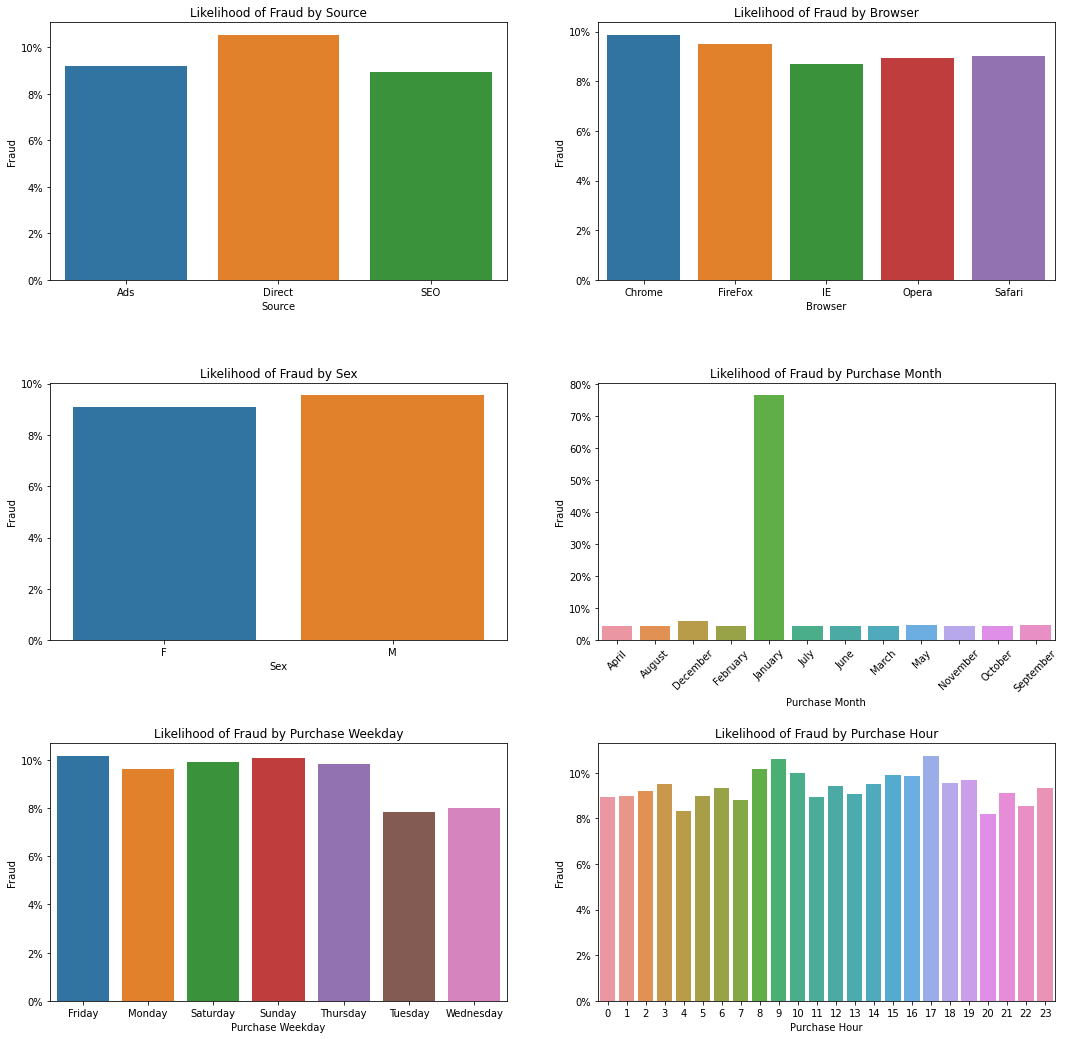

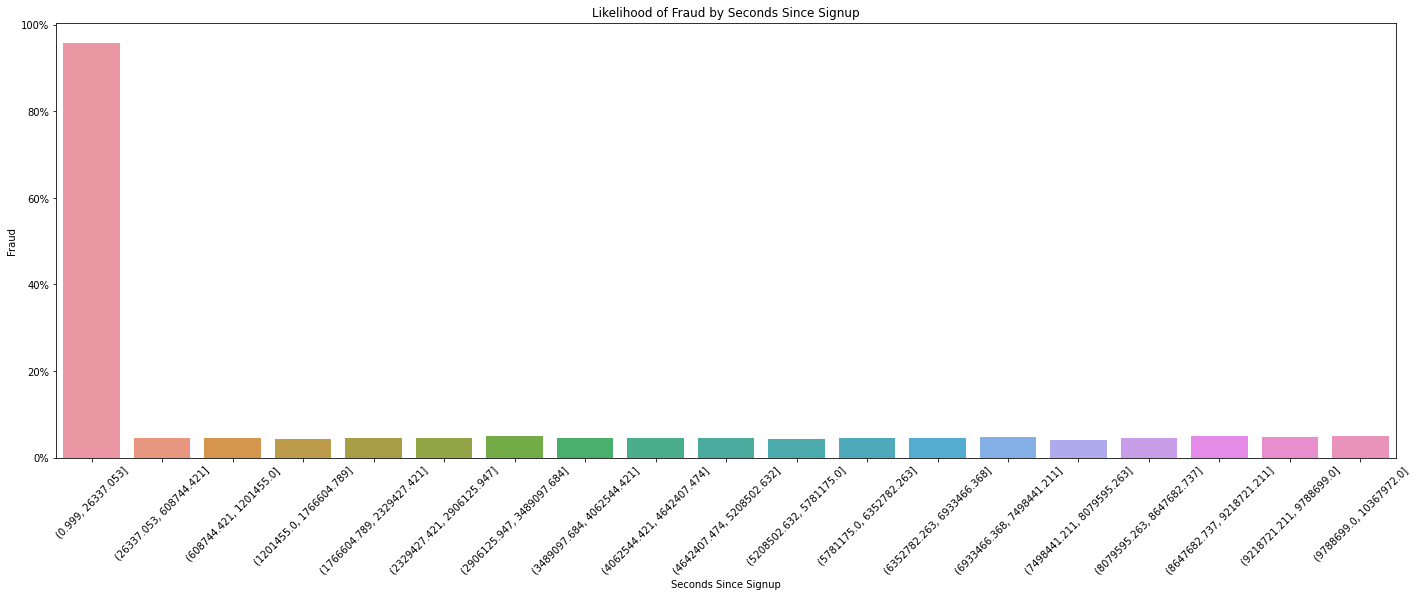

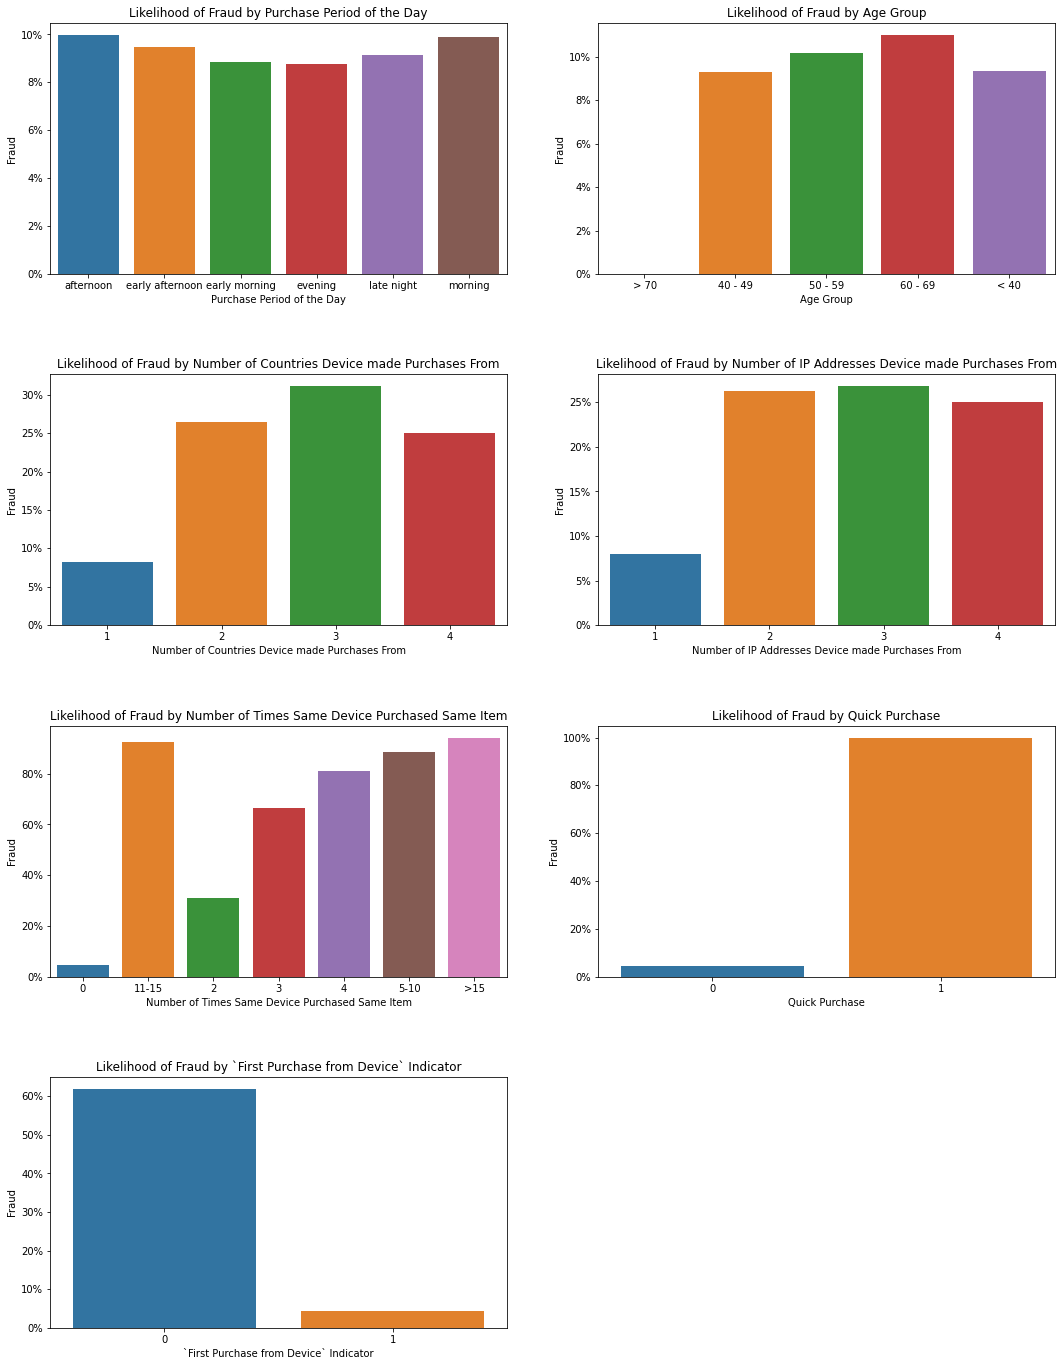

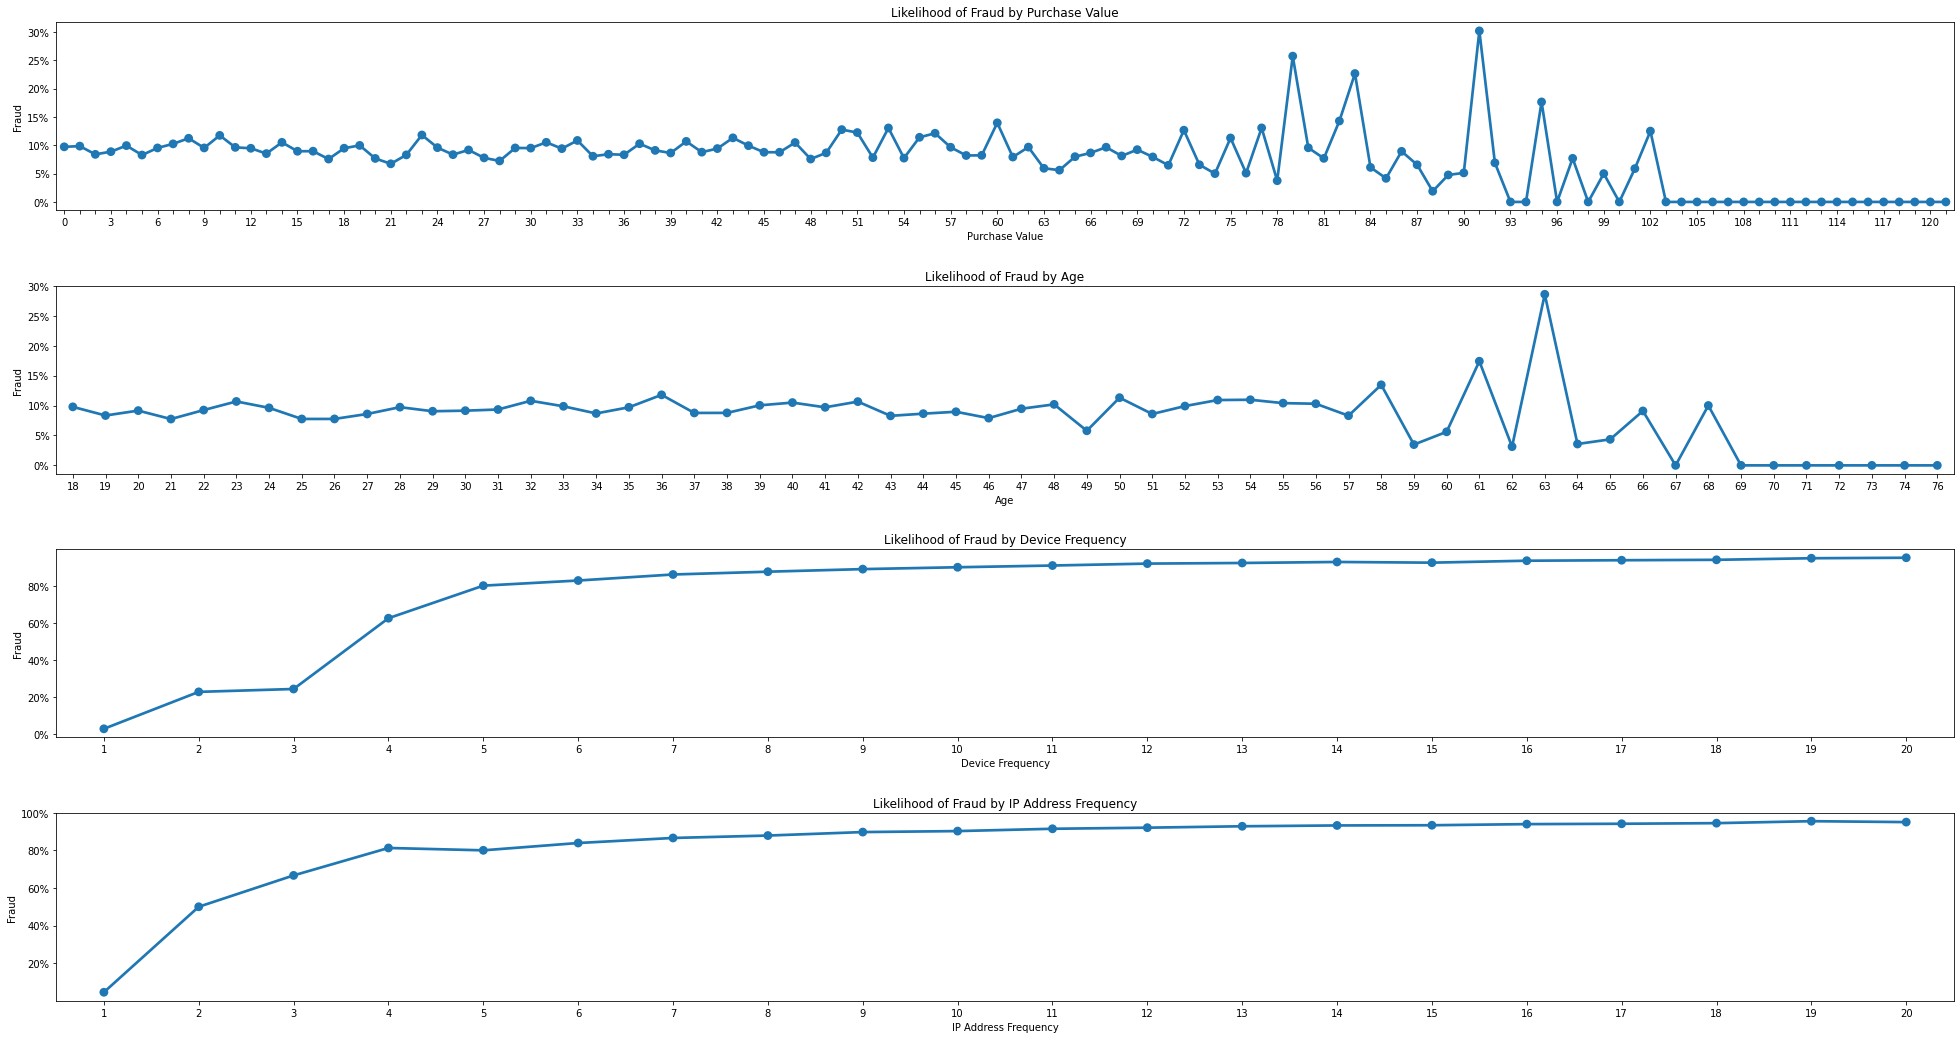

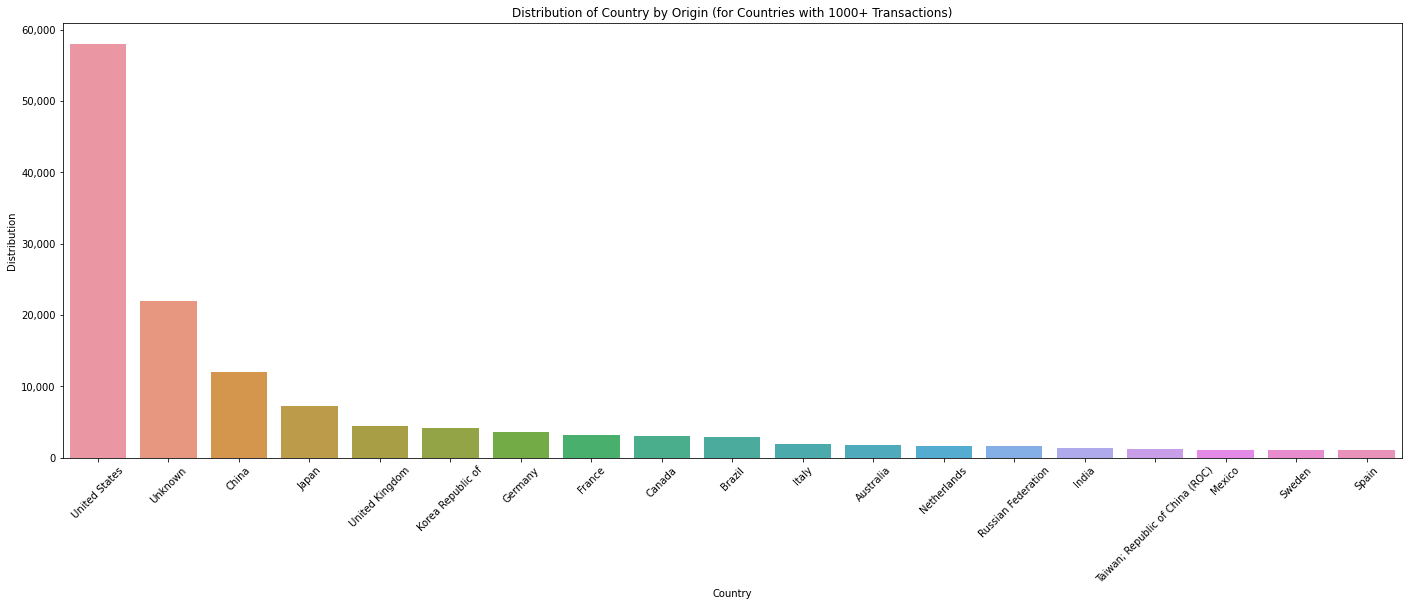

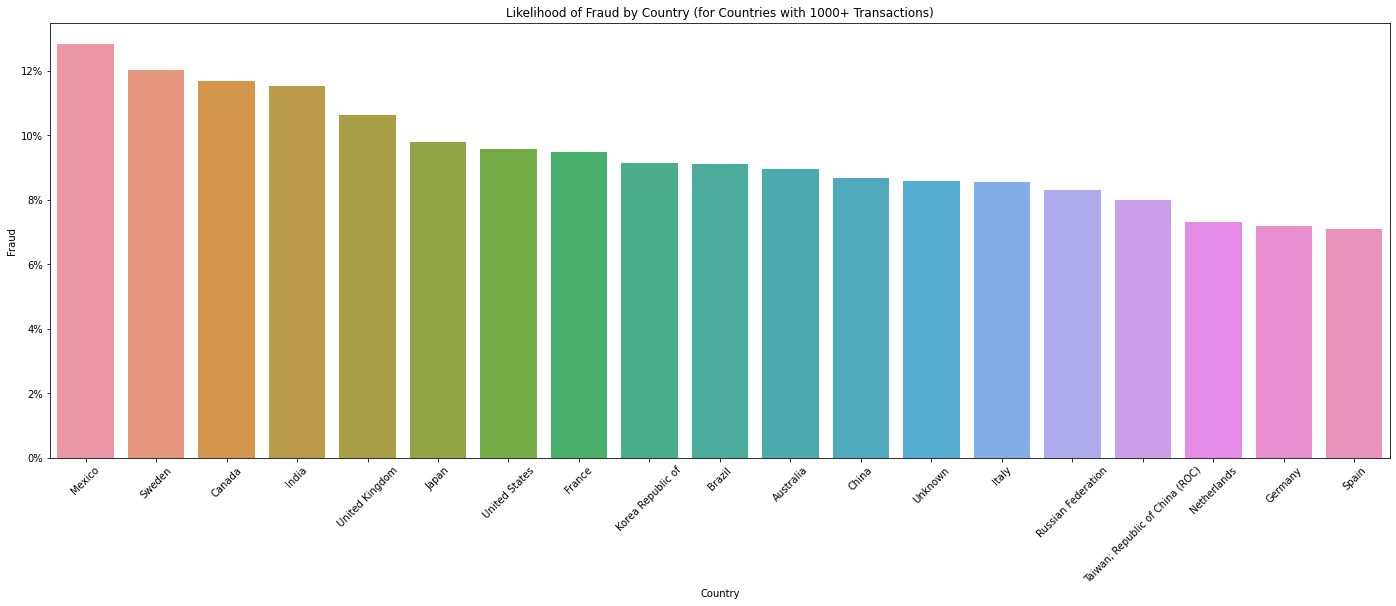

In [82]:
# We look at the likelihood of fraud per category

f, ax = plt.subplots(3, 2, figsize =(18, 18))
f.subplots_adjust(hspace=0.4)

f2, ax2 = plt.subplots(1, 1, figsize =(24, 8))

f3, ax3 = plt.subplots(4, 2, figsize =(18, 24))
f3.subplots_adjust(hspace=0.4)
f3.delaxes(ax3[3,1])

f4, ax4 = plt.subplots(4, 1, figsize =(34, 18))
f4.subplots_adjust(hspace=0.4)

f5, ax5 = plt.subplots(1, 1, figsize =(24, 8))

f6, ax6 = plt.subplots(1, 1, figsize =(24, 8))

# Direct sources have the highest likelihood of fraud at 10.5%, followed by ads at 9.2%, then SEO at 8.9%
sns.barplot(fraud_data.groupby('source')['class'].mean().index, fraud_data.groupby('source')['class'].mean(), ax = ax[0, 0])
ax[0, 0].set_title('Likelihood of Fraud by Source')
ax[0, 0].set_xlabel('Source')
ax[0, 0].set_ylabel('Fraud')
ax[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Chrome browsers have the highest likelihood of fraud at 9.9%, followed by FireFox (9.5%), Safari (9.0%), Opera (8.9%) and IE (8.7%)
sns.barplot(fraud_data.groupby('browser')['class'].mean().index, fraud_data.groupby('browser')['class'].mean(), ax = ax[0, 1])
ax[0, 1].set_title('Likelihood of Fraud by Browser')
ax[0, 1].set_xlabel('Browser')
ax[0, 1].set_ylabel('Fraud')
ax[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Males have a higher likelihood of fraud at 9.65% compared to females (9.1%)
sns.barplot(fraud_data.groupby('sex')['class'].mean().index, fraud_data.groupby('sex')['class'].mean(), ax = ax[1, 0])
ax[1, 0].set_title('Likelihood of Fraud by Sex')
ax[1, 0].set_xlabel('Sex')
ax[1, 0].set_ylabel('Fraud')
ax[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# January has, by far, the highest likelihood of fraud at 76.5%. December comes in second, with a much lower 6.0% fraud occurrence. 
# This may be related to holiday shopping and returns, following Christmas and Black Friday (Day after Thanksgiving).
sns.barplot(fraud_data.groupby('purchase_month')['class'].mean().index, fraud_data.groupby('purchase_month')['class'].mean(), ax = ax[1, 1])
ax[1, 1].set_title('Likelihood of Fraud by Purchase Month')
ax[1, 1].set_xlabel('Purchase Month')
ax[1, 1].set_ylabel('Fraud')
ax[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax[1, 1].set_xticklabels(fraud_data.groupby('purchase_month')['class'].mean().index, rotation = 45)

# Weekends have the highest occurence of Fraud, with Fridays at 10.2%, Sundays at 10.1% and Saturdays at 9.9%. Next comes Thursday (9.8%), Monday (9.6%),
# Wednesday (8.0%) and Tuesday (7.8%)
sns.barplot(fraud_data.groupby('purchase_weekday')['class'].mean().index, fraud_data.groupby('purchase_weekday')['class'].mean(), ax = ax[2, 0])
ax[2, 0].set_title('Likelihood of Fraud by Purchase Weekday')
ax[2, 0].set_xlabel('Purchase Weekday')
ax[2, 0].set_ylabel('Fraud')
ax[2, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# The peaks for fraud likelihood are in the evening, at 10.7% around 8pm, and then the morning, at 10.6% around 9am.
sns.barplot(fraud_data.groupby('purchase_hour')['class'].mean().index, fraud_data.groupby('purchase_hour')['class'].mean(), ax = ax[2, 1])
ax[2, 1].set_title('Likelihood of Fraud by Purchase Hour')
ax[2, 1].set_xlabel('Purchase Hour')
ax[2, 1].set_ylabel('Fraud')
ax[2, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely when a purchase is made in the first 7 hours and 19 minutes (26,337 seconds) after signup, with an occurence of 95.7%, compared with a 
# range of 4.1% to 5.0% for times periods after the first 7 hours and 19 minutes. Thus, quicker purchases are more likely to be fraudulent.
sns.barplot(fraud_data.groupby('seconds_since_signup_cat')['class'].mean().index, fraud_data.groupby('seconds_since_signup_cat')['class'].mean(), ax = ax2)
ax2.set_title('Likelihood of Fraud by Seconds Since Signup')
ax2.set_xlabel('Seconds Since Signup')
ax2.set_ylabel('Fraud')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.set_xticklabels(fraud_data.groupby('seconds_since_signup_cat')['class'].mean().index, rotation = 45) 

# Mornings and afternoons have the highest likelihood of fraud with afternoons at 10.0%, mornings at 9.9% and early afternoons
# at 9.5%
sns.barplot(fraud_data.groupby('purchase_period_of_day')['class'].mean().index, fraud_data.groupby('purchase_period_of_day')['class'].mean(), ax = ax3[0, 0])
ax3[0, 0].set_title('Likelihood of Fraud by Purchase Period of the Day')
ax3[0, 0].set_xlabel('Purchase Period of the Day')
ax3[0, 0].set_ylabel('Fraud')
ax3[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is highest for those between the ages of 60 and 69 (at 11.0%) followed by those between the ages of 50 and 59 (at 10.2%).
sns.barplot(fraud_data.groupby('age_group')['class'].mean().index, fraud_data.groupby('age_group')['class'].mean(), ax = ax3[0, 1])
ax3[0, 1].set_title('Likelihood of Fraud by Age Group')
ax3[0, 1].set_xlabel('Age Group')
ax3[0, 1].set_ylabel('Fraud')
ax3[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is highest (31.1%) when purchases from the same device are made from three countries, followed by two countries (26.4%)
# and then four countries (25.0%)
sns.barplot(fraud_data.groupby('countries_from_device')['class'].mean().index, fraud_data.groupby('countries_from_device')['class'].mean(), ax = ax3[1, 0])
ax3[1, 0].set_title('Likelihood of Fraud by Number of Countries Device made Purchases From')
ax3[1, 0].set_xlabel('Number of Countries Device made Purchases From')
ax3[1, 0].set_ylabel('Fraud')
ax3[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is higher when purchases from the same device are made from multiple IP addresses, with 3 IP addresses at 26.8%, 2 IP 
# addresses at 26.3% and 4 IP addresses at 25.0%.
sns.barplot(fraud_data.groupby('ip_addresses_from_device')['class'].mean().index, fraud_data.groupby('ip_addresses_from_device')['class'].mean(), ax = ax3[1, 1])
ax3[1, 1].set_title('Likelihood of Fraud by Number of IP Addresses Device made Purchases From')
ax3[1, 1].set_xlabel('Number of IP Addresses Device made Purchases From')
ax3[1, 1].set_ylabel('Fraud')
ax3[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is higher the more the same device makes purchases for the same item, with 15 or more purchases at 94.3%, 11 to 15
# purchases at 92.4%, 5 to 10 at 88.5% and progressively lower from 4 (81.3%) to none (4.5%).
sns.barplot(fraud_data.groupby('same_purchase_freq')['class'].mean().index, fraud_data.groupby('same_purchase_freq')['class'].mean(), ax = ax3[2, 0])
ax3[2, 0].set_title('Likelihood of Fraud by Number of Times Same Device Purchased Same Item')
ax3[2, 0].set_xlabel('Number of Times Same Device Purchased Same Item')
ax3[2, 0].set_ylabel('Fraud')
ax3[2, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Within our data, fraud is guaranteed when purchases are made less than 137 seconds after signing up. Whereas fraud occurs in only
# 4.6% of purchase transactions made 137 seconds or more after signing up.
sns.barplot(fraud_data.groupby('quick_purchase')['class'].mean().index, fraud_data.groupby('quick_purchase')['class'].mean(), ax = ax3[2, 1])
ax3[2, 1].set_title('Likelihood of Fraud by Quick Purchase')
ax3[2, 1].set_xlabel('Quick Purchase')
ax3[2, 1].set_ylabel('Fraud')
ax3[2, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is more likely to occur after one purchase has been made from that device. For the first purchase from the device, fraud
# occurred only 4.4% compared to 61.9% in subsequent purchases from that device.
sns.barplot(fraud_data.groupby('first_purchase')['class'].mean().index, fraud_data.groupby('first_purchase')['class'].mean(), ax = ax3[3, 0])
ax3[3, 0].set_title('Likelihood of Fraud by `First Purchase from Device` Indicator')
ax3[3, 0].set_xlabel('`First Purchase from Device` Indicator')
ax3[3, 0].set_ylabel('Fraud')
ax3[3, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is more likely for purchase values between an $80 and $104 range, where the likelihood ranges between 12.7% and 30.2%.
sns.pointplot(data = fraud_data, x = 'purchase_value', y = 'class', ci = None, ax = ax4[0])
ax4[0].set_title('Likelihood of Fraud by Purchase Value')
ax4[0].set_xlabel('Purchase Value')
ax4[0].set_ylabel('Fraud')
ax4[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

original_labels = [label for label in ax4[0].get_xticks()]
min_lab = min(original_labels)
max_lab = max(original_labels)
labels_of_interest = [i for i in np.arange(min_lab, max_lab, 3)]
new_labels = [label if label in labels_of_interest else '' for label in original_labels]
ax4[0].set_xticklabels(new_labels)

# Fraud peaks around the early 60s, with the highest likelihood at 63 with 28.6%, followed by 61 at 17.4% and 58 with 13.4%.
sns.pointplot(data = fraud_data, x = 'age', y = 'class', ci = None, ax = ax4[1])
ax4[1].set_title('Likelihood of Fraud by Age')
ax4[1].set_xlabel('Age')
ax4[1].set_ylabel('Fraud')
ax4[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely to occur when purchases are made from the same device. Device frequencies of 20 have the highest likelihood of fraud, at 95%, followed by 
# device frequencies of 19, 18, and 17, and then progressively dropping until we reach the lowest likelihood of fraud, with purchases from only one device, at 
# only 3.0% likelihood.
sns.pointplot(data = fraud_data, x = 'device_freq', y = 'class', ci = None, ax = ax4[2])
ax4[2].set_title('Likelihood of Fraud by Device Frequency')
ax4[2].set_xlabel('Device Frequency')
ax4[2].set_ylabel('Fraud')
ax4[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely to occur when purchases are made from the same IP address. IP address frequencies of 19 have the highest likelihood of fraud, at 95.5%, 
# followed by IP address frequencies of 20 at 95%, and 18 at 94.4%, and then progressively dropping mostly sequentially until we reach the lowest likelihood of 
# fraud, with purchases from only one IP address at 4.6% likelihood.
sns.pointplot(data = fraud_data, x = 'ip_address_freq', y = 'class', ci = None, ax = ax4[3])
ax4[3].set_title('Likelihood of Fraud by IP Address Frequency')
ax4[3].set_xlabel('IP Address Frequency')
ax4[3].set_ylabel('Fraud')
ax4[3].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Evaluating countries, we see that fraud is most likely to occur in Turkmenistan (100%), Namibia (43.5%), Sri Lanka (41.9%), Luxembourg (38.9%) and the 
# U.S. Virgin Islands (33.3%). However, the number of transactions for these countries are sparse within our dataset.
# When we limit the analysis to countries with at least 1,000 transactions within our dataset, we see that fraud is most likely to occur in Mexico (12.0%), 
# followed by Sweden (12.0%), then Canada (11.7%), India (11.5%), United Kingdom (10.6%), Japan (9.8%) and then the United States (9.6%). 
# I am keeping unknown countries in the dataset because they may be an indication of a fraudulent activity since fraudsters go to great lengths to avoid being traced.
sns.barplot(fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000].index, fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000], ax = ax5)
ax5.set_title('Distribution of Country by Origin (for Countries with 1000+ Transactions)')
ax5.set_xlabel('Country')
ax5.set_ylabel('Distribution')
ax5.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 
ax5.set_xticklabels(fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000].index, rotation = 45)  

sns.barplot(fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False).index[:28], fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False)[:28], ax = ax6)
ax6.set_title('Likelihood of Fraud by Country (for Countries with 1000+ Transactions)')
ax6.set_xlabel('Country')
ax6.set_ylabel('Fraud')
ax6.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax6.set_xticklabels(fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False).index[:28], rotation = 45)  

After reviewing visuals, it is apparent that our highest predictors of fraud are:
- Quick Purchases: Specifically, purchases made 136 seconds or less after sign up are guaranteed to be fraudulent.
- January Purchases: Purchases made in the month of January are 76.5% likely to be fraudulent.
- Same Purchase Frequency of Three or More: Purchases made three or more times from the same device for the same item, with 15 or more purchases at 94.3%, 11 to 15 purchases at 92.4%, 5 to 10 at 88.5%, 4 at 81.3% and 3 at 66.7%.
- Subsequent Purchases: For subsequent purchases from the same device, fraud occurred 61.9% of the time compared to 4.4% for first purchases.

We have specific indicators for most high-risk categories, except January. A January variable will ease analysis. 

In [83]:
fraud_data['january_purchase'] = fraud_data.purchase_month.apply(lambda x : 1 if x == 'January' else 0)

In [84]:
# fraud_data['january_purchase'].value_counts()

In [85]:
# fraud_data.info()

In [86]:
fraud_data.to_csv('data/Fraud_Data_after_Feature_Eng.csv')

### Drop columns not needed for modeling

In [87]:
fraud_data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'age', 'ip_address', 'country', 'purchase_hour',
                 'seconds_since_signup', 'seconds_since_signup_cat', 'seconds_since_signup_cat_str'], axis = 1, inplace = True)

In [88]:
# fraud_data.info()

### Check for multicollinearity and drop columns as needed

In [89]:
fraud_data_nums = fraud_data.select_dtypes('int64')
fraud_data_nums.corr()

,purchase_value,class,countries_from_device,ip_addresses_from_device,device_freq,ip_address_freq,quick_purchase,first_purchase,january_purchase
purchase_value,1.000000,0.001011,0.005320,0.004015,0.003829,0.003266,0.000268,-0.001522,-0.002225
class,0.001011,1.000000,0.150998,0.164712,0.670837,0.658625,0.715925,-0.557224,0.616517
countries_from_device,0.005320,0.150998,1.000000,0.897209,0.093674,-0.005079,-0.007385,-0.400957,-0.005986
ip_addresses_from_device,0.004015,0.164712,0.897209,1.000000,0.103401,-0.006607,-0.008056,-0.445645,-0.006596
device_freq,0.003829,0.670837,0.093674,0.103401,1.000000,0.991083,0.911735,-0.728838,0.799346
ip_address_freq,0.003266,0.658625,-0.005079,-0.006607,0.991083,1.000000,0.920170,-0.683048,0.806340
quick_purchase,0.000268,0.715925,-0.007385,-0.008056,0.911735,0.920170,1.000000,-0.663571,0.860001
first_purchase,-0.001522,-0.557224,-0.400957,-0.445645,-0.728838,-0.683048,-0.663571,1.000000,-0.575664
january_purchase,-0.002225,0.616517,-0.005986,-0.006596,0.799346,0.806340,0.860001,-0.575664,1.000000


Device Frequency and IP Address Frequency are highly correlated. A device ID is more effective in fraud detection since it is more unique than an IP address. It is even better when used in conjunction with an IP address since a device can have several IP addresses. I could keep **ip_addresses_from_device** but delete **ip_address_freq** due to its high correlation with **device_freq**. However, IP Addresses from Device and Countries from Device are highly correlated so both **ip_address_freq** and **ip_addresses_from_device** will need to be dropped.

Device Frequency and Quick Purchase are also highly correlated, but this is more of a coincidence. Both **device_freq** and **quick_purchase** still need to be analyzed as predictors.

Likewise, January Purchase is also highly correlated with Quick purchase because a lot of fraudulent purchases were both quick and made in the month of January. However, both **january_purchase** and **quick_purchase** need to be analyzed as predictors.


In [90]:
fraud_data.drop(['ip_address_freq', 'ip_addresses_from_device'], axis = 1, inplace = True)

## Modeling

For the models, I want to minimize both false negatives (i.e. fraud not detected) and false positives (i.e. blocked transactions which were actually not fraudulent) so the evaluation metric that is most relevant would be accuracy. However, a disadvantage of using accuracy as a metric is that it can be misleadingly high when there is a significant class imbalance. Earlier, I found that the proportion of fraud in this dataset (as measured by the 'class' column) is 9.36%. Because there are fewer observations in the fraud class (i.e. the minority class), it may be harder for a model to effectively learn the decision boundary. This can be solved by oversampling observations in the minority class by synthesizing new observation from the minority class using SMOTE (Synthetic Minority Oversampling Technique).

We will include SMOTE in the following data pre-processing steps.


### Define predictor (X) and target (y) variables

In [91]:
X = fraud_data.drop('class', axis=1)
y = fraud_data['class']

### Split the data between train and test sets

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.3)

### Perform one-hot encoding for categorical columns

In [93]:
# Specify the categorical columns to encode
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder(drop = 'first', sparse = False)

# Transform the categorical columns in both the training and testing sets
X_train_dummies = pd.DataFrame(ohe.fit_transform(X_train_cat), columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_dummies = pd.DataFrame(ohe.fit_transform(X_test_cat), columns=ohe.get_feature_names_out(), index=X_test_cat.index)

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Normalize numerical columns by scaling the train and test sets

In [94]:
# Specify the numerical columns to scale
X_train_nums = X_train.select_dtypes('int64')
X_test_nums = X_test.select_dtypes('int64')

# Create an instance of the StandardScaler
ss = StandardScaler()

# Transform the numerical columns in both the training and testing sets
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nums), index = X_train_nums.index)
X_test_scaled = pd.DataFrame(ss.fit_transform(X_test_nums), index = X_test_nums.index)

X_train_scaled.columns = X_train_nums.columns
X_test_scaled.columns = X_test_nums.columns


### Merge the pre-processed categorical and numerical columns

In [95]:
X_train_clean = pd.concat([X_train_scaled, X_train_dummies], axis = 1)
X_test_clean = pd.concat([X_test_scaled, X_test_dummies], axis = 1)

X_train_clean.columns = X_train_clean.columns.astype(str)
X_test_clean.columns = X_test_clean.columns.astype(str)

In [96]:
y_train

65950     0
142388    0
88275     0
118009    0
66729     0
         ..
83659     0
138615    0
17363     0
27404     0
122175    0
Name: class, Length: 105778, dtype: int64

### Perform SMOTE to address the class imbalance of the fraud variable

In [97]:
# Create an instance of SMOTE
smote = SMOTE(random_state = 42)

# Apply SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train)

### MODEL 1: Apply a Dummy Classifier as the Baseline Model

I used a DummyClassifier as a simple baseline model so we can compare its accuracy to more complex classification models that take input features in consideration.

In [98]:
# Create a baseline model
dummy_model = DummyClassifier(strategy = 'most_frequent', random_state = 42)

# Train the model on the resampled training data
dummy_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_dummy = dummy_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41089
           1       0.00      0.00      0.00      4245

    accuracy                           0.91     45334
   macro avg       0.45      0.50      0.48     45334
weighted avg       0.82      0.91      0.86     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

I use a Dummy Classifier as a simple baseline model so we can compare its accuracy to more complex classification models that take input features in consideration.

With an accuracy score of 91%, the baseline model correctly identifies transactions that are fraudulent and not fraudulent 91% of the time. This is not surprising since our 9.36% of transactions are fraudulent. The baseline model’s accuracy is equivalent to the class split of the target variable within the data.

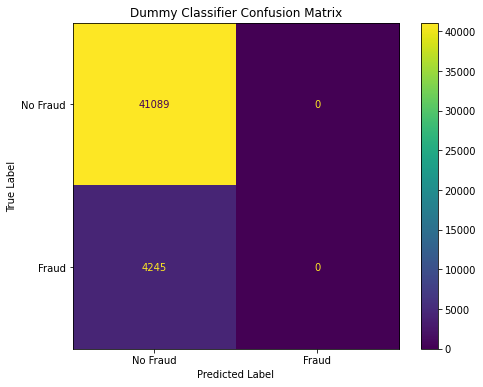

In [99]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_dummy)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Dummy Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

Calculating the accuracy by hand using the formula, **Accuracy** = $\frac{TP + TN}{TP + TN + FP + FN}$, I can confirm that the accuracy is indeed 91%.

**Accuracy** = $\frac{0 + 41089}{0 + 41089 + 0 + 4245}$ = 90.6%

### MODEL 2: Apply a Decision Tree Model

Next, I used a Decision Tree Classifier to identify to predict the value of the fraud target variable based on several input variables. This will help to identify predictors that could be more useful in subsequent models.

To reduce overfitting, I initially set the maximum depth of the decision tree classifier to 3.

In [100]:
# Create an instance of the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)

# Train the model on the resampled training data
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_dt = dt_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     41089
           1       0.09      1.00      0.17      4245

    accuracy                           0.09     45334
   macro avg       0.05      0.50      0.09     45334
weighted avg       0.01      0.09      0.02     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

With an accuracy score of only 9%, the decision tree does not perform as well as other models I will use. I verify the accuracy by hand, **Accuracy** = $\frac{4245 + 0}{4245 + 0 + 41089 + 0}$ = 9.4%, and confirm that it is indeed 9%, exactly the complement of the accuracy for the baseline model.

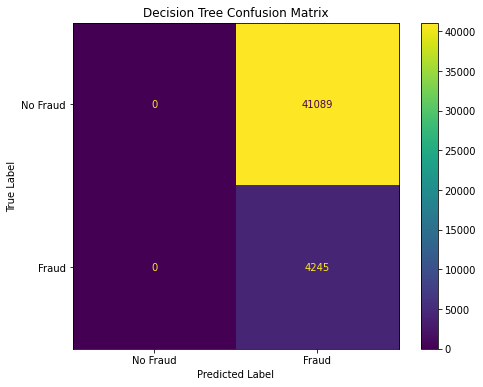

In [101]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

Even with a low accuracy calculation, the decision tree classifier helps to identify device frequency and quick purchases are influential predictors of fraudulent transactions. Transactions made with U.S. IP addresses also appear to be strong predictors. However, this is expected since most transactions were made using IP addresses within the United States.

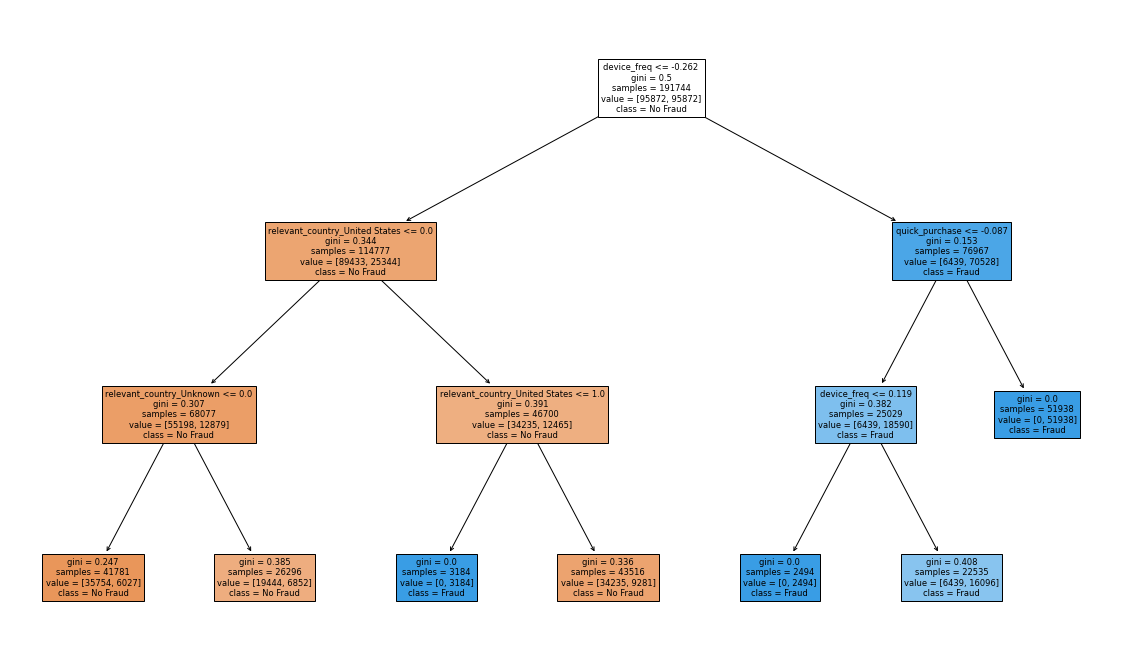

In [102]:
# Plot the decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(dt_model, feature_names = X_train_clean.columns, class_names=['No Fraud', 'Fraud'], filled = True)
plt.show()

In [103]:
feature_imp = {}
for fi, feature in zip(dt_model.feature_importances_, dt_model.feature_names_in_):
    feature_imp[feature] = fi

feature_imp

{'purchase_value': 0.0,
 'countries_from_device': 0.0,
 'device_freq': 0.8706032039796375,
 'quick_purchase': 0.043307911431644364,
 'first_purchase': 0.0,
 'january_purchase': 0.0,
 'source_Direct': 0.0,
 'source_SEO': 0.0,
 'browser_FireFox': 0.0,
 'browser_IE': 0.0,
 'browser_Opera': 0.0,
 'browser_Safari': 0.0,
 'sex_M': 0.0,
 'relevant_country_Australia': 0.0,
 'relevant_country_Brazil': 0.0,
 'relevant_country_Canada': 0.0,
 'relevant_country_China': 0.0,
 'relevant_country_Colombia': 0.0,
 'relevant_country_France': 0.0,
 'relevant_country_Germany': 0.0,
 'relevant_country_India': 0.0,
 'relevant_country_Indonesia': 0.0,
 'relevant_country_Italy': 0.0,
 'relevant_country_Japan': 0.0,
 'relevant_country_Korea Republic of': 0.0,
 'relevant_country_Mexico': 0.0,
 'relevant_country_Netherlands': 0.0,
 'relevant_country_Norway': 0.0,
 'relevant_country_Poland': 0.0,
 'relevant_country_Romania': 0.0,
 'relevant_country_Russian Federation': 0.0,
 'relevant_country_South Africa': 0.0,
 

To see if I get better metrics, I increase the maximum depth parameter to 4. This gives us a slightly better accuracy score of 10%, which I verify by hand, **Accuracy** = $\frac{4232 + 232}{4232 + 232 + 40857 + 13}$ = 9.8%, and confirm that it is indeed 10%, slightly higher than the decision tree classifier with a depth parameter of 3.

In [104]:
# Create a second instance of the DecisionTreeClassifier with less pruning
dt_model2 = DecisionTreeClassifier(max_depth = 4, random_state = 42)

# Train the model on the resampled training data
dt_model2.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_dt2 = dt_model2.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_dt2))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.01      0.01     41089
           1       0.09      1.00      0.17      4245

    accuracy                           0.10     45334
   macro avg       0.52      0.50      0.09     45334
weighted avg       0.87      0.10      0.03     45334



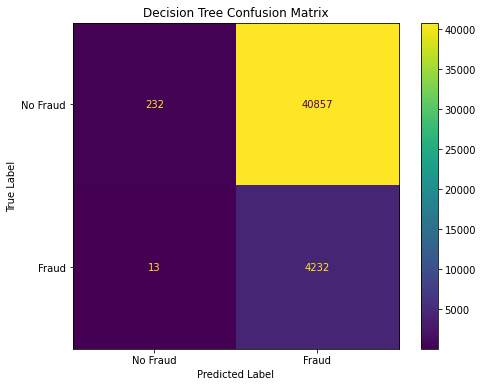

In [105]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_dt2)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

Increasing the depth parameter to 4 does not really add much value in terms of both the accuracy score and identifying relevant predictors. Device frequency and quick purchases are still found to be key determinants of fraudulent transactions. Transactions made with U.S. are still shown to be important. The model also highlights transactions made in China and unknown countries, as well as the sex of the purchaser being male. These additional predictors make sense because transactions from China and unknown countries are heavily represented in our data, as well as male purchasers. Scammers go to great lengths to avoid being tracked so I expected IP addresses that could not be traced to a country to be highlighted.

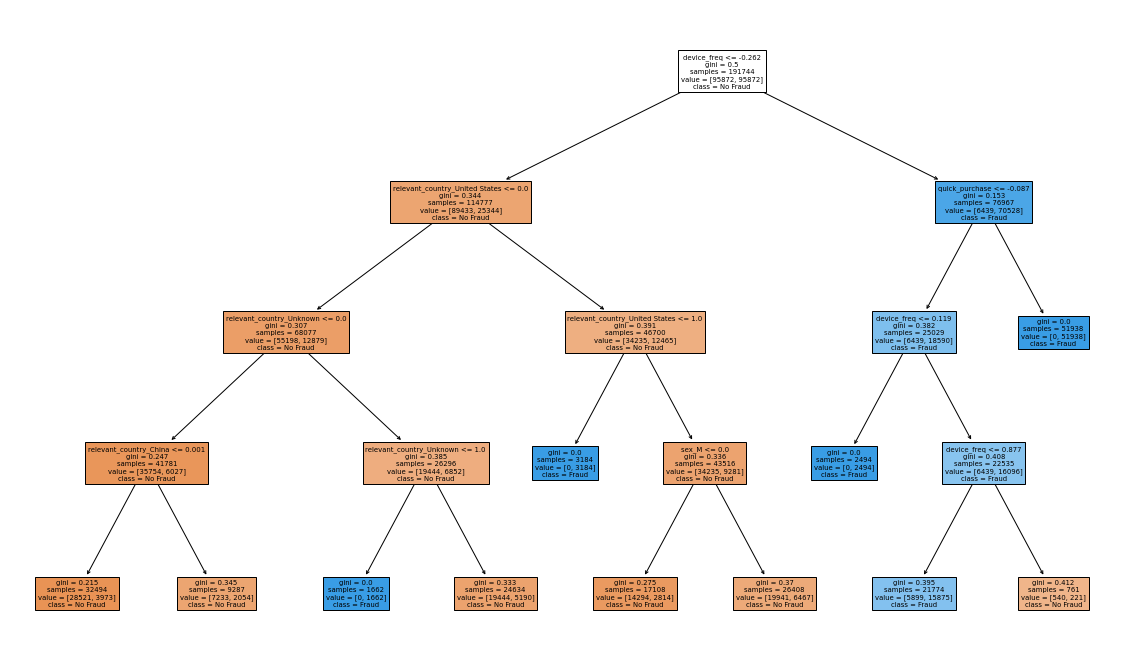

In [106]:
# Plot the decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(dt_model2, feature_names = X_train_clean.columns, class_names=['No Fraud', 'Fraud'], filled = True)
plt.show()

In [107]:
feature_imp = {}
for fi, feature in zip(dt_model2.feature_importances_, dt_model2.feature_names_in_):
    feature_imp[feature] = fi

feature_imp

{'purchase_value': 0.0,
 'countries_from_device': 0.0,
 'device_freq': 0.8356397016550908,
 'quick_purchase': 0.041308549824712555,
 'first_purchase': 0.0,
 'january_purchase': 0.0,
 'source_Direct': 0.0,
 'source_SEO': 0.0,
 'browser_FireFox': 0.0,
 'browser_IE': 0.0,
 'browser_Opera': 0.0,
 'browser_Safari': 0.0,
 'sex_M': 0.0024802828272371363,
 'relevant_country_Australia': 0.0,
 'relevant_country_Brazil': 0.0,
 'relevant_country_Canada': 0.0,
 'relevant_country_China': 0.002610742369586513,
 'relevant_country_Colombia': 0.0,
 'relevant_country_France': 0.0,
 'relevant_country_Germany': 0.0,
 'relevant_country_India': 0.0,
 'relevant_country_Indonesia': 0.0,
 'relevant_country_Italy': 0.0,
 'relevant_country_Japan': 0.0,
 'relevant_country_Korea Republic of': 0.0,
 'relevant_country_Mexico': 0.0,
 'relevant_country_Netherlands': 0.0,
 'relevant_country_Norway': 0.0,
 'relevant_country_Poland': 0.0,
 'relevant_country_Romania': 0.0,
 'relevant_country_Russian Federation': 0.0,
 'rel

### MODEL 3: Apply a Logistic Regression Model

Moving on to models that provide quantifiable insights, I use a simple binomial logistic regression model to determine the likelihood of fraud given our predictor variables.

This model has the highest accuracy score so far, at 92%. I verify the accuracy by hand, **Accuracy** = $\frac{2943 + 38751}{2943 + 38751 + 2338 + 1302}$ = 92.0%, and confirm that it is indeed 92%.

In [108]:
# Create an instance of the logistic regression model
logreg_model = LogisticRegression(random_state = 42)

# Train the model on the resampled training data
logreg_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_logreg = logreg_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_logreg))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     41089
           1       0.56      0.69      0.62      4245

    accuracy                           0.92     45334
   macro avg       0.76      0.82      0.79     45334
weighted avg       0.93      0.92      0.92     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [109]:
logreg_coefficients = logreg_model.coef_
logreg_intercept = logreg_model.intercept_

# Create a DataFrame to display the coefficients
X_train_logreg_coefficients = pd.DataFrame(logreg_coefficients, columns=X_train_clean.columns)
X_train_logreg_coefficients['Intercept'] = logreg_intercept

# Print the coefficients
print('Coefficients:')
print(X_train_logreg_coefficients)

Coefficients:
   purchase_value  countries_from_device  device_freq  quick_purchase  \
0       -0.014657               0.293979     2.119838        4.701775   

   first_purchase  january_purchase  source_Direct  source_SEO  \
0       -0.134283         -0.070523      -0.035935   -0.111897   

   browser_FireFox  browser_IE  ...  purchase_weekday_Sunday  \
0        -0.139867   -0.165646  ...                -0.278947   

   purchase_weekday_Thursday  purchase_weekday_Tuesday  \
0                  -0.373752                 -0.225842   

   purchase_weekday_Wednesday  purchase_period_of_day_early afternoon  \
0                   -0.278692                                -0.23868   

   purchase_period_of_day_early morning  purchase_period_of_day_evening  \
0                             -0.150503                       -0.179111   

   purchase_period_of_day_late night  purchase_period_of_day_morning  \
0                          -0.179242                       -0.143894   

   Intercept  
0 

Via the the odds of its coefficients, the logistic regression model tells financial institutions that a purchase made within the first 137 seconds of signing up for a credit card is 110 times more likely to be fraudulent than a purchase made after 137 seconds.

It also tells us that a one unit increase in device frequency is 8 times more likely to be fraudulent. That means a device used one additional time for a purchase within our dataset is 8 more likely to be making a fraudulent purchase.

In [200]:
logreg_odds = np.exp(logreg_coefficients)

# Create a DataFrame to display the odds
X_train_logreg_odds = pd.DataFrame(logreg_odds, columns=X_train_clean.columns)

X_train_logreg_odds_transposed = X_train_logreg_odds.transpose()

X_train_logreg_odds_transposed = X_train_logreg_odds_transposed.sort_values(X_train_logreg_odds_transposed.columns[0], ascending = False)

# Print the odds
print('Odds:')
print(X_train_logreg_odds_transposed[:25])

Odds:
                                       0
quick_purchase                       110
device_freq                            8
age_group_< 40                         2
age_group_40 - 49                      2
countries_from_device                  1
same_purchase_freq_2                   1
age_group_50 - 59                      1
age_group_60 - 69                      1
sex_M                                  1
purchase_month_January                 1
purchase_value                         1
source_Direct                          1
january_purchase                       1
source_SEO                             1
first_purchase                         1
same_purchase_freq_3                   1
browser_FireFox                        1
purchase_period_of_day_morning         1
purchase_period_of_day_early morning   1
purchase_weekday_Saturday              1
browser_IE                             1
purchase_period_of_day_evening         1
purchase_period_of_day_late night      1
browser_Sa

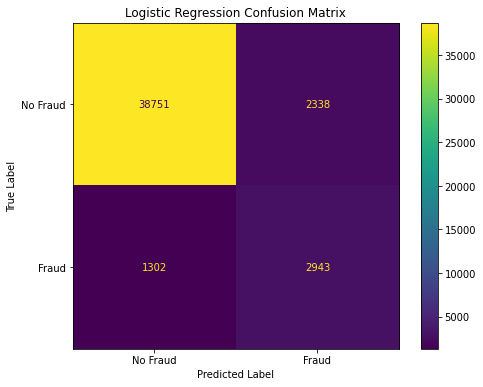

In [111]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

In [112]:
logreg_scores = logreg_model.predict_proba(X_test_clean)

Use a Receiver Operating Characteristic (ROC) curve to plot the True Positive Rate vs. he False Positive Rate. 

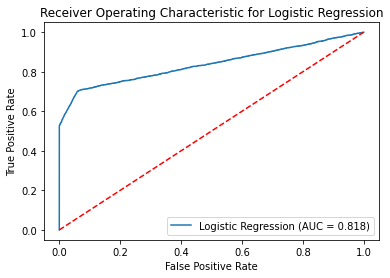

In [113]:
logreg_roc_auc = roc_auc_score(y_test, y_pred_logreg)
fpr, tpr, thresholds = roc_curve(y_test, logreg_scores[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.3f)' % logreg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc='lower right')
plt.savefig('logreg_roc')
plt.show()

Since we want our y-values (True Positive Rates) to be as high as possible for any particular x-value, a larger Area Under the Curve (AUC) indicates a better classifier. In this case, the AUC is 81.8%.

We want to set the appropriate level of threshold to reduce the number of false negatives (i.e. fraud not detected) without unduly increasing the cost of false positives (i.e. blocked transactions which were actually not fraudulent). We can examine the true- and false-positive rates for various thresholds:

In [114]:
def classify_rates(y_test, y_probs, thresh):
    y_hat = []
    for val in y_probs:                 
        if val[1] < thresh:             
            y_hat.append(0)             
        else:                           
            y_hat.append(1)             
    cm = confusion_matrix(y_test, y_hat)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

In [115]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {round(x, 2)}: '\
          + classify_rates(y_test, logreg_scores, x)[2])

Rates at threshold = 0.0: tpr:1.0, fpr:1.0
Rates at threshold = 0.1: tpr:0.998, fpr:0.993
Rates at threshold = 0.2: tpr:0.922, fpr:0.752
Rates at threshold = 0.3: tpr:0.747, fpr:0.194
Rates at threshold = 0.4: tpr:0.706, fpr:0.067
Rates at threshold = 0.5: tpr:0.693, fpr:0.057
Rates at threshold = 0.6: tpr:0.671, fpr:0.048
Rates at threshold = 0.7: tpr:0.629, fpr:0.034
Rates at threshold = 0.8: tpr:0.559, fpr:0.01
Rates at threshold = 0.9: tpr:0.532, fpr:0.002
Rates at threshold = 1.0: tpr:0.0, fpr:0.0


One way of choosing a threshold is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where the True Positive Rate is 0 and the False Positive Rate is 1. So let's find that point as well:

In [116]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(y_test, logreg_scores, x)[1])
    tprs.append(classify_rates(y_test, logreg_scores, x)[0])
    diffs.append(np.sqrt(tprs[-1]**2 + (1-fprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f'''The optimal threshold for the Logistic Regression Model is {(max_dist - 1) / 100} when: \n'''
      f'''\tThe True Positive Rate is {round(tprs[max_dist], 3)} \n'''
      f'''\tand the False Positive Rate is {round(fprs[max_dist], 3)}''')

The optimal threshold for the Logistic Regression Model is 0.46 when: 
	The True Positive Rate is 0.699 
	and the False Positive Rate is 0.059


In [117]:
# Changing the threshold from the 0.5 default to 0.4:
y_pred_new_threshold = (logreg_scores[:, 1] >= 0.4).astype(int)
print(y_pred_new_threshold)

[0 0 0 ... 0 0 0]


In [118]:
# Evaluation metrics for default threshold
print('Evaluation metrics with threshold 0.5:')
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Precision:', precision_score(y_test, y_pred_logreg))
print('Recall:', recall_score(y_test, y_pred_logreg))
print('F1 score:', f1_score(y_test, y_pred_logreg))

Evaluation metrics with threshold 0.5:
Accuracy: 0.9197070631314246
Precision: 0.5572808180268889
Recall: 0.6932862190812721
F1 score: 0.6178878857862692


In [119]:

# Evaluation metrics for new threshold
print('Evaluation metrics with threshold 0.9:')
print('Accuracy:', accuracy_score(y_test, y_pred_new_threshold))
print('Precision:', precision_score(y_test, y_pred_new_threshold))
print('Recall:', recall_score(y_test, y_pred_new_threshold))
print('F1 score:', f1_score(y_test, y_pred_new_threshold))

Evaluation metrics with threshold 0.9:
Accuracy: 0.9120748224290819
Precision: 0.5225649067781843
Recall: 0.7064782096584217
F1 score: 0.600761217948718


Choosing a different threshold does not yield better results as the default threshold of 0.5 has a better accuracy score.

### MODEL 4: Apply a Logistic Regression Model with Lasso Regularization

A LASSO regression model can set the coefficients for features it does not consider interesting to zero, thereby providing greater prediction accuracy compared to other regression models. Lasso regularization also helps to increase model interpretation since less important features of the dataset are penalized. 

The accuracy score with lasso regularization is comparable to the score of the previous logistic regression model, at 92%. I verify the accuracy by hand, **Accuracy** = $\frac{2996 + 38538}{2996 + 38538 + 2551 + 1249}$ = 91.6%, and confirm that it is indeed 92% but slightly lower than the accuracy score of the logistic regression model with no regularization penalty applied.

In [120]:
# Create an instance of the logistic regression model with lasso (L1 penalty) regularization
lassoreg_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=1e-6, class_weight='balanced', random_state = 42)

# Train the model on the resampled training data
lassoreg_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_lassoreg = lassoreg_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_lassoreg))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     41089
           1       0.54      0.71      0.61      4245

    accuracy                           0.92     45334
   macro avg       0.75      0.82      0.78     45334
weighted avg       0.93      0.92      0.92     45334



In [121]:
# Get the coefficients and intercept from the logistic regression model with lasso (L1 penalty) regularization
lassoreg_coefficients = lassoreg_model.coef_
lassoreg_intercept = lassoreg_model.intercept_

# Create a DataFrame to display the coefficients
X_train_lassoreg_coefficients = pd.DataFrame(lassoreg_coefficients, columns=X_train_clean.columns)
X_train_lassoreg_coefficients['Intercept'] = lassoreg_intercept

# Print the coefficients
print('Coefficients:')
print(X_train_lassoreg_coefficients)

Coefficients:
   purchase_value  countries_from_device  device_freq  quick_purchase  \
0       -0.013046               0.173594     3.671715        3.365329   

   first_purchase  january_purchase  source_Direct  source_SEO  \
0       -0.083177         -0.046631       -0.03519   -0.105743   

   browser_FireFox  browser_IE  ...  purchase_weekday_Sunday  \
0        -0.147986   -0.164952  ...                -0.276908   

   purchase_weekday_Thursday  purchase_weekday_Tuesday  \
0                  -0.375605                 -0.228884   

   purchase_weekday_Wednesday  purchase_period_of_day_early afternoon  \
0                    -0.27636                               -0.237809   

   purchase_period_of_day_early morning  purchase_period_of_day_evening  \
0                             -0.150183                       -0.176664   

   purchase_period_of_day_late night  purchase_period_of_day_morning  \
0                          -0.175675                       -0.140516   

   Intercept  
0 

As expected, the odds of the lasso regression coefficients have a tighter range than the logistic regression model since the regularization penalty is applied to the coefficients. 

The models tells us that a purchase made within the first 137 seconds of signing up for a credit card is 39 times more likely to be fraudulent than a purchase made after 137 seconds.

It also tells us that a one unit increase in device frequency is 29 times more likely to be fraudulent. That means a device used one additional time for a purchase within our dataset is 29 more likely to be making a fraudulent purchase.

In [201]:
lassoreg_odds = np.exp(lassoreg_coefficients)

# Create a DataFrame to display the odds
X_train_lassoreg_odds = pd.DataFrame(lassoreg_odds, columns=X_train_clean.columns)

X_train_lassoreg_odds_transposed = X_train_lassoreg_odds.transpose()

X_train_lassoreg_odds_transposed = X_train_lassoreg_odds_transposed.sort_values(X_train_lassoreg_odds_transposed.columns[0], ascending = False)

# Suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.0f}'.format

# Print the odds
print('Odds:')
print(X_train_lassoreg_odds_transposed[:25])

Odds:
                                      0
device_freq                          39
quick_purchase                       29
age_group_< 40                        2
age_group_40 - 49                     1
countries_from_device                 1
age_group_50 - 59                     1
sex_M                                 1
same_purchase_freq_2                  1
purchase_month_January                1
same_purchase_freq_3                  1
age_group_60 - 69                     1
purchase_value                        1
source_Direct                         1
january_purchase                      1
first_purchase                        1
source_SEO                            1
purchase_period_of_day_morning        1
browser_FireFox                       1
purchase_period_of_day_early morning  1
purchase_weekday_Saturday             1
browser_IE                            1
purchase_period_of_day_late night     1
purchase_period_of_day_evening        1
browser_Safari                    

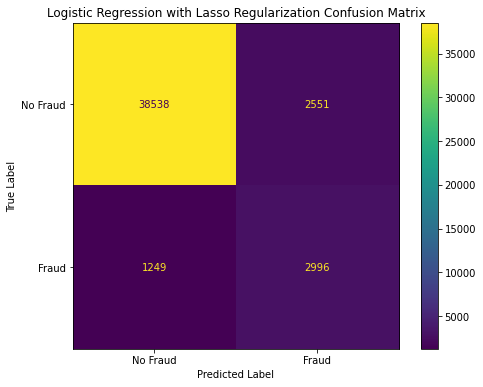

In [123]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_lassoreg)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Logistic Regression with Lasso Regularization Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

In [124]:
lassoreg_scores = lassoreg_model.predict_proba(X_test_clean)

Evaluating the lasso model with a Receiver Operating Characteristic (ROC) curve, we see that it has a slightly larger Area Under the Curve (AUC) of 82.2% compared to the logistic regression model (81.8%), suggesting it is still a strong classifier despite a slightly lower accuracy than the simple logistic regression model.

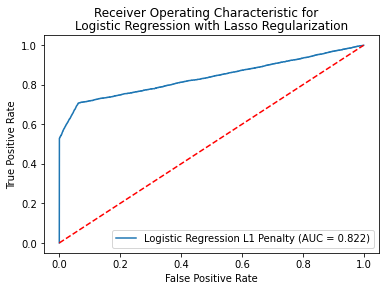

In [125]:
lassoreg_roc_auc = roc_auc_score(y_test, y_pred_lassoreg)
fpr, tpr, thresholds = roc_curve(y_test, lassoreg_scores[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression L1 Penalty (AUC = %0.3f)' % lassoreg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('Receiver Operating Characteristic for')
plt.title('Logistic Regression with Lasso Regularization')
plt.legend(loc='lower right')
plt.savefig('lassoreg_roc')
plt.show()

In [126]:
# Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization
print('Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization:')
print('Accuracy:', accuracy_score(y_test, y_pred_lassoreg))
print('Precision:', precision_score(y_test, y_pred_lassoreg))
print('Recall:', recall_score(y_test, y_pred_lassoreg))
print('F1 score:', f1_score(y_test, y_pred_lassoreg))

Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization:
Accuracy: 0.9161777032690696
Precision: 0.5401117721290788
Recall: 0.705771495877503
F1 score: 0.6119281045751633


### MODEL 5: Apply a Naive Bayes Classifier Model using a Mixed Naive Bayes Library

Next, I looked at more complex models, beginning with Naive Bayes classifiers. Naive Bayes classifiers can have more outstanding performance in detecting credit card fraud relative to other machine learning algorithms.

Our predictors are a mix of categorical (e.g. purchase month and country) and continuous (e.g. purchase value and device frequency) data. Of scikit-learn's Naive Bayes classifiers, [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) would be most suitable for continuous data, while [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) or [Categorical Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) could be used for the categorical data. However, since I have both categorical and continuous predictors, there are three approaches available for a mixed Naive Bayes model.

1. Mixed NB (Gaussian + Categorical) Approach 1 — Convert continuous variables into categorical ones through binning and then train a categorical model.

2. Mixed NB (Gaussian + Categorical) Approach 2 — Train two separate models using continuous and categorical variables and then train the final model based on predictions from the first two models.

3. Mixed NB (Gaussian + Categorical) Approach 3 — Use the [Mixed Naive Bayes](https://github.com/remykarem/mixed-naive-bayes) library that assume a mix of Gaussian and categorical (multinoulli) distributions on the training data features. It is written in NumPy such that the APIs are similar to scikit-learn's.

I chose approach 3 and installed the mixed-naive-bayes using `pip install mixed-naive-bayes`.

In [127]:
# fraud_data.info()

Determine the columns with categorical features and the columns with numerical features

In [128]:
fraud_data_nums = fraud_data.select_dtypes('int64')
fraud_data_nums.columns

Index(['purchase_value', 'class', 'countries_from_device', 'device_freq',
       'quick_purchase', 'first_purchase', 'january_purchase'],
      dtype='object')

In [129]:
fraud_data_cats = fraud_data.select_dtypes('object')
fraud_data_cats.columns

Index(['source', 'browser', 'sex', 'relevant_country', 'age_group',
       'same_purchase_freq', 'purchase_month', 'purchase_weekday',
       'purchase_period_of_day'],
      dtype='object')

In [130]:
# Categorical features are in columns 6 through 72, while numerical features are in columns 0 through 5.
# X_train_resampled.info()

My initial approach on the Mixed Naive Bayes model is to classify the pre-processed predictor variables that have One Hot Encoding, Standard Scaling, and SMOTE applied. With this approach, I get an accuracy score of only 9%. I verify the accuracy by hand, **Accuracy** = $\frac{4245 + 0}{4245 + 0 + 41089 + 0}$ = 9.4%, and confirm that it is indeed 9%, identical to the accuracy score of the decision tree classifier with a maximum depth of 3.

In [131]:
cat_columns = list(range(6, 73))
max_categories = [2] * 67

X_train_mnb = np.array(X_train_resampled)
y_train_mnb = np.array(y_train_resampled)

# Create an instance of the Mixed Naive Bayes model
mnb_model = MixedNB(categorical_features = cat_columns, max_categories= max_categories)

# Train the model on the resampled training data
mnb_model.fit(X_train_mnb, y_train_mnb)

# Predict on the testing data
y_pred_mnb = mnb_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_mnb))

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:427: UserWarning: Feature no. 6 is continuous data. Casting data to integer.
  warnings.warn(f"Feature no. {feature_no} is continuous data. " +
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:427: UserWarning: Feature no. 7 is continuous data. Casting data to integer.
  warnings.warn(f"Feature no. {feature_no} is continuous data. " +
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:427: UserWarning: Feature no. 8 is continuous data. Casting data to integer.
  warnings.warn(f"Feature no. {feature_no} is continuous data. " +
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:427: UserWarning: Feature no. 9 is continuous data. Casting data to integer.
  warnings.warn(f"Feature no. {feature_no} is continuous data. " +


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     41089
           1       0.09      1.00      0.17      4245

    accuracy                           0.09     45334
   macro avg       0.05      0.50      0.09     45334
weighted avg       0.01      0.09      0.02     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

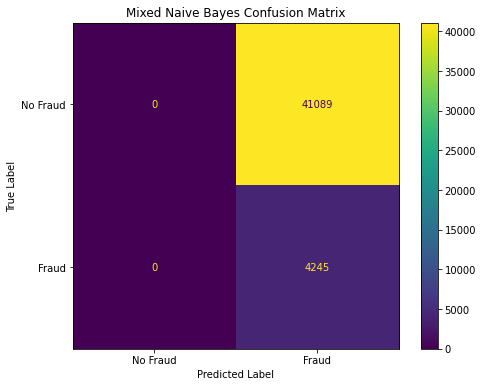

In [132]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_mnb)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Mixed Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

The evaluation metrics for the Mixed Naive Bayes model are relatively poor. I can try running the Naive Bayes model on the data prior to our previous pre-processing steps.

In [133]:
X_nums = X.dtypes[X.dtypes == 'int64'].index.tolist()
X_nums_indices = [X.columns.get_loc(col) for col in X_nums]
X_nums_indices

[0, 5, 7, 12, 13, 14]

In [134]:
X_cats = X.dtypes[X.dtypes == 'object'].index.tolist()
X_cats_indices = [X.columns.get_loc(col) for col in X_cats]
X_cats_indices

[1, 2, 3, 4, 6, 8, 9, 10, 11]

In [135]:
max_categories2 = X.select_dtypes(include='object').nunique().values

X_train_mnb2 = np.array(X_train)
X_test_mnb2 = np.array(X_test)
y_train_mnb2 = np.array(y_train)

label_encoder = LabelEncoder()

for X_cat_index in X_cats_indices:
    X_train_mnb2[: , X_cat_index] = label_encoder.fit_transform(X_train_mnb2[: , X_cat_index])
    X_test_mnb2[: , X_cat_index] = label_encoder.fit_transform(X_test_mnb2[: , X_cat_index])

X_train_mnb2 = X_train_mnb2.astype(float)
X_test_mnb2 = X_test_mnb2.astype(float)
        
# Create an instance of the Mixed Naive Bayes model
mnb_model2 = MixedNB(categorical_features = X_cats_indices, max_categories= max_categories2)

# Train the model on the resampled training data
mnb_model2.fit(X_train_mnb2, y_train_mnb2)

# Predict on the testing data
y_pred_mnb2 = mnb_model2.predict(X_test_mnb2)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_mnb2))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     41089
           1       0.58      0.62      0.60      4245

    accuracy                           0.92     45334
   macro avg       0.77      0.78      0.78     45334
weighted avg       0.92      0.92      0.92     45334



For the Naive Bayes model to perform well, I have to strip out all prior pre-processing (One Hot Encoding, Standard Scaling, and SMOTE) to begin with the bare bones predictor variables and only encode using Label Encoder. After doing this, I get an accuracy score of 92% on the Mixed Naive Bayes classifier. I verify the accuracy by hand, **Accuracy** = $\frac{2615 + 39189}{2615 + 39189 + 1900 + 1630}$ = 92.2%, and confirm that it is indeed 92%, and slightly higher than both the logistic and lasso regression models at the one decimal place level.

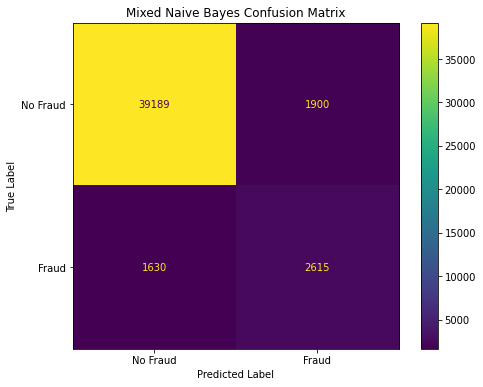

In [136]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_mnb2)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Mixed Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

In [137]:
# Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization
print('Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization:')
print('Accuracy:', accuracy_score(y_test, y_pred_mnb2))
print('Precision:', precision_score(y_test, y_pred_mnb2))
print('Recall:', recall_score(y_test, y_pred_mnb2))
print('F1 score:', f1_score(y_test, y_pred_mnb2))

Evaluation metrics for logistic regression model with lasso (L1 penalty) regularization:
Accuracy: 0.9221334980367936
Precision: 0.5791805094130675
Recall: 0.6160188457008245
F1 score: 0.5970319634703195


Because Naive Bayes classifiers are not linear classifiers, they do not compute coefficients to determine a decision function. Instead, they compute the conditional probabilities of a sample being a certain class given that a feature vector has certain values. The class with the highest probability is then considered the most likely class. For our purposes of communicating to financial institutions the likelihood of fraud given certain characteristics of a transaction, it is easier to interpret the coefficients of the logistic and lasso models. Therefore, we will gather our quantifiable insights from those models instead of the Naive Bayes classifier.

### MODEL 6: Apply a Naive Bayes Classifier Model using the Gaussian Naive Bayes class

Because I got low performance on the Mixed Naive Bayes classifier on data that was pre-processed with one hot encoding, standard scaling and SMOTE, I want to see if using a Gaussian Naive Bayes classifier on the pre-processed data will yield better results. 

With the Gaussian Naive Bayes classifier, I get an accuracy score of only 9%. I verify the accuracy by hand, **Accuracy** = $\frac{4245 + 0}{4245 + 0 + 41089 + 0}$ = 9.4%, and confirm that it is indeed 9%, identical to the accuracy scores of the decision tree classifier with a maximum depth of 3 and the Naive Bayes classifier on pre-processed predictors.

In [138]:
# Create an instance of the Gaussian Naive Bayes model
gnb_model = GaussianNB()

# Train the model on the resampled training data
gnb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_gnb = gnb_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_gnb))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     41089
           1       0.09      1.00      0.17      4245

    accuracy                           0.09     45334
   macro avg       0.05      0.50      0.09     45334
weighted avg       0.01      0.09      0.02     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

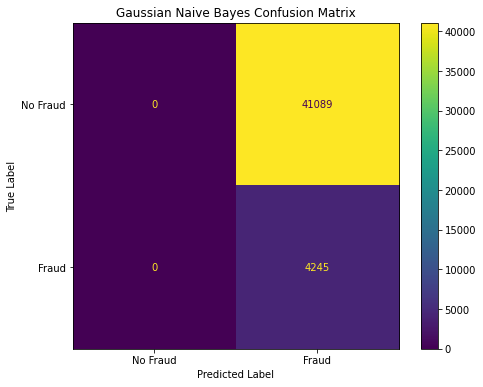

In [139]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_gnb)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

### MODEL 7: Apply Ensemble (Bagging) Methods using Grid Search on a Random Forest Model

Finally, I look at ensemble methods, beginning with a bagging approach using a Random Forest Classifier to see if I can getter stronger model performance than the logistic and Lasso models. To explore different combinations of Random Forest hyperparameters, I use grid search cross-validation.

The best hyperparameters for the Random Forest estimator were a maximum tree depth of 4, a minimum of 5 samples to split a node and 70 trees in the forest. 

With this combination of hyperparamters, I get an accuracy score of only 45%. I verify the accuracy by hand, **Accuracy** = $\frac{3692 + 16779}{3692 + 16779 + 24310 + 553}$ = 45.2%, and confirm that it is indeed 45%, providing no competition to the logistic and Lasso models.

In [140]:
# Create an instance of the random forest model
rf_model = RandomForestClassifier(random_state=42)

params = {'max_depth' : np.arange(1,5),
         'min_samples_leaf' : [1, 5, 10, 20],
         "n_estimators" : np.arange(10,100,20)}

# Create an instance of Grid Search CV on the random forest model
gsrf =  GridSearchCV(estimator=rf_model,   
                     param_grid= params, 
                     cv = 10,            
                     n_jobs =-1)  

# Train the model on the resampled training data
gsrf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model's performance
gsrf_best_params = gsrf.best_params_
print('Best Parameters:')
for k, v in gsrf_best_params.items():
    print("  " + str(k) + " => " + str(v))

print('\nBest Score:')
print(round(gsrf.best_score_, 5))

gsrf_best_estimator_params = gsrf.best_estimator_.get_params()
print('\nBest Estimator Parameters:')
for k, v in gsrf_best_estimator_params.items():
    print("  " + str(k) + " => " + str(v))

print("\nBest Estimator's Score:")
gsrf_best_estimator_score = gsrf.best_estimator_.score(X_test_clean, y_test)
print(round(gsrf_best_estimator_score, 5))

# Predict on the testing data
y_pred_rf = gsrf.best_estimator_.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))

Best Parameters:
  max_depth => 4
  min_samples_leaf => 5
  n_estimators => 70

Best Score:
0.83451

Best Estimator Parameters:
  bootstrap => True
  ccp_alpha => 0.0
  class_weight => None
  criterion => gini
  max_depth => 4
  max_features => sqrt
  max_leaf_nodes => None
  max_samples => None
  min_impurity_decrease => 0.0
  min_samples_leaf => 5
  min_samples_split => 2
  min_weight_fraction_leaf => 0.0
  n_estimators => 70
  n_jobs => None
  oob_score => False
  random_state => 42
  verbose => 0
  warm_start => False

Best Estimator's Score:
0.45156

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.41      0.57     41089
           1       0.13      0.87      0.23      4245

    accuracy                           0.45     45334
   macro avg       0.55      0.64      0.40     45334
weighted avg       0.89      0.45      0.54     45334



In [141]:
pd.DataFrame(gsrf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.042549,0.305579,0.091951,0.016966,1,1,10,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.809857,0.809961,...,0.820704,0.814853,0.812089,0.816470,0.819808,0.808386,0.815271,0.814404,0.004014,45
1,1.967567,0.208344,0.099921,0.037572,1,1,30,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.764798,0.761617,...,0.771317,0.782414,0.778815,0.781788,0.784030,0.780901,0.767967,0.773990,0.008028,77
2,2.537915,0.145206,0.103782,0.028169,1,1,50,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.800417,0.808866,...,0.816949,0.813915,0.810733,0.815062,0.816001,0.810368,0.816053,0.812151,0.004683,49
3,3.260224,0.208811,0.154889,0.070823,1,1,70,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.800313,0.799113,...,0.806832,0.799677,0.795922,0.800146,0.801763,0.796600,0.802180,0.800322,0.002884,65
4,3.951030,0.428737,0.117960,0.037851,1,1,90,"{'max_depth': 1, 'min_samples_leaf': 1, 'n_est...",0.793950,0.792282,...,0.800522,0.799677,0.795922,0.800146,0.801763,0.796600,0.797590,0.797146,0.003179,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.037715,0.103274,0.029488,0.008259,4,20,10,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_es...",0.824146,0.829987,...,0.841252,0.831491,0.831751,0.833472,0.840618,0.828361,0.837123,0.833528,0.005196,16
76,3.169407,0.682860,0.103832,0.057114,4,20,30,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_es...",0.814602,0.829674,...,0.839896,0.834203,0.832273,0.834463,0.841661,0.829352,0.838427,0.833168,0.007320,19
77,5.762724,0.434994,0.132900,0.051489,4,20,50,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_es...",0.820026,0.831186,...,0.840678,0.834046,0.831856,0.834359,0.841139,0.828779,0.838218,0.833825,0.006033,12
78,7.070319,0.455237,0.157883,0.051326,4,20,70,"{'max_depth': 4, 'min_samples_leaf': 20, 'n_es...",0.825502,0.831760,...,0.841982,0.833890,0.831178,0.833890,0.841139,0.828674,0.838271,0.834425,0.005103,3


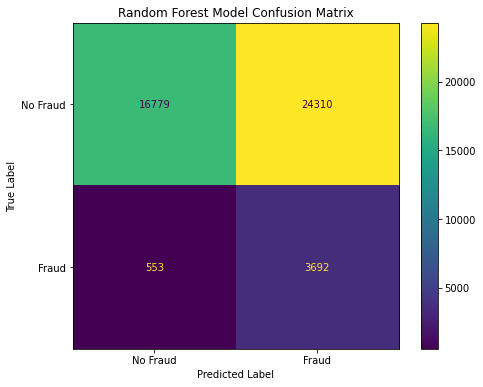

In [142]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Random Forest Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

In [143]:
y_train_resampled

0         0
1         0
2         0
3         0
4         0
         ..
191739    1
191740    1
191741    1
191742    1
191743    1
Name: class, Length: 191744, dtype: int64

### MODEL 8: Apply Ensemble (Boosting) Methods using Gradient Boosting Classifier

Next, I try a boosting approach for ensemble methods using Gradient Boosting Classifiers to see if I get better results. I first try gradient boosting and then adaptive boosting.

For gradient boosting, I get an accuracy score of only 11%. I verify the accuracy by hand, **Accuracy** = $\frac{4030 + 979}{4030 + 979 + 40110 + 215}$ = 11.0%, and confirm that it is indeed 11%.

In [203]:
# Create an instance of the Gradient Boosting Classifier model
gbc_model = GradientBoostingClassifier(random_state=42)

# Train the model on the resampled training data
gbc_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_gbc = gbc_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_gbc))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.02      0.05     41089
           1       0.09      0.95      0.17      4245

    accuracy                           0.11     45334
   macro avg       0.46      0.49      0.11     45334
weighted avg       0.75      0.11      0.06     45334



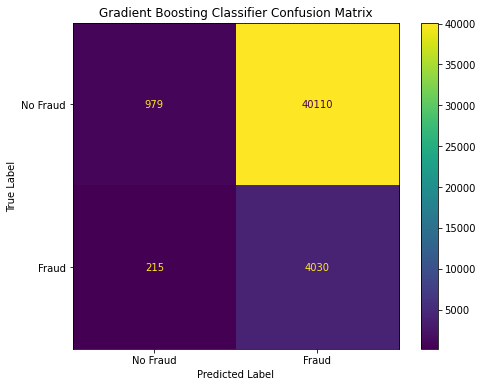

In [214]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_gbc)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, values_format= 'd')

# Add a title and axis labels
plt.title('Gradient Boosting Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

### MODEL 9: Apply Ensemble (Boosting) Methods using Adaptive Boosting Classifier

For adaptive boosting, I get an accuracy score of only 10%. I verify the accuracy by hand, **Accuracy** = $\frac{4088 + 473}{4088 + 473 + 40616 + 157}$ = 10.1%, and confirm that it is indeed 10%, even lower than the gradient boosting approach.

In [146]:
# Create an instance of the Adaptive Boosting Classifier model
abc_model = AdaBoostClassifier(random_state=42)

# Train the model on the resampled training data
abc_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_abc = abc_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('Classification Report:')
print(classification_report(y_test, y_pred_abc))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.01      0.02     41089
           1       0.09      0.96      0.17      4245

    accuracy                           0.10     45334
   macro avg       0.42      0.49      0.09     45334
weighted avg       0.69      0.10      0.04     45334



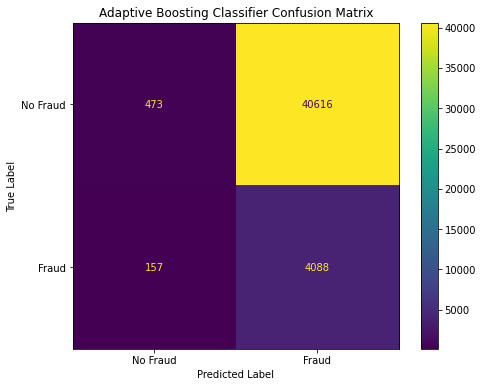

In [147]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_abc)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Adaptive Boosting Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()

### MODEL 10: Apply Ensemble (Boosting) Methods using Grid Search on a Gradient Boosting Classifier

As a final attempt to improve performance with ensemble methods, I use grid search cross validation on a Gradient Boosting Classifier since it had slightly better performance compared to the adaptive approach. 

The best hyperparameters for the Gradient Boosting Classifier were a learning rate that shrinks the contribution of each tree by 45%, a log_loss function for binomial deviance and 90 boosting stages to perform. 

With this combination of hyperparamters, I get an accuracy score of only 16%, slightly better than the score of the earlier Gradient Boosting Classifier, but still bad overall. I verify the accuracy by hand, **Accuracy** = $\frac{3444 + 3759}{3444 + 3759 + 37330 + 801}$ = 15.9%, and confirm that it is indeed 16%, providing no competition to the logistic and Lasso models.

In [148]:
# Create an instance of the Gradient Boosting Classifier model
gsgbc_model = GradientBoostingClassifier(random_state=42)

params = {'loss': ['log_loss', 'exponential'],
          "learning_rate" : np.arange(0.1,0.5,0.05),
          "n_estimators" : np.arange(10,100,10)}

# Create an instance of Grid Search CV on the random forest model
gsgbc =  GridSearchCV(estimator=gsgbc_model,   
                     param_grid= params, 
                     cv = 10,            
                     n_jobs =-1,
                     error_score='raise')  

# Train the model on the resampled training data
gsgbc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model's performance
gsgbc_best_params = gsgbc.best_params_
print('Best Parameters:')
for k, v in gsgbc_best_params.items():
    print("  " + str(k) + " => " + str(v))

print('\nBest Score:')
print(round(gsgbc.best_score_, 5))

gsgbc_best_estimator_params = gsgbc.best_estimator_.get_params()
print('\nBest Estimator Parameters:')
for k, v in gsgbc_best_estimator_params.items():
    print("  " + str(k) + " => " + str(v))

print("\nBest Estimator' Score:")
gsgbc_best_estimator_score = gsgbc.best_estimator_.score(X_test_clean, y_test)
print(round(gsgbc_best_estimator_score, 5))

# Predict on the testing data
y_pred_gsgbc = gsgbc.best_estimator_.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred_gsgbc))

Best Parameters:
  learning_rate => 0.45000000000000007
  loss => log_loss
  n_estimators => 90

Best Score:
0.97265

Best Estimator Parameters:
  ccp_alpha => 0.0
  criterion => friedman_mse
  init => None
  learning_rate => 0.45000000000000007
  loss => log_loss
  max_depth => 3
  max_features => None
  max_leaf_nodes => None
  min_impurity_decrease => 0.0
  min_samples_leaf => 1
  min_samples_split => 2
  min_weight_fraction_leaf => 0.0
  n_estimators => 90
  n_iter_no_change => None
  random_state => 42
  subsample => 1.0
  tol => 0.0001
  validation_fraction => 0.1
  verbose => 0
  warm_start => False

Best Estimator' Score:
0.15889

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.09      0.16     41089
           1       0.08      0.81      0.15      4245

    accuracy                           0.16     45334
   macro avg       0.45      0.45      0.16     45334
weighted avg       0.76      0.16      0.16     45334



In [149]:
pd.DataFrame(gsgbc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.757877,0.149960,0.035970,0.009351,0.1,log_loss,10,"{'learning_rate': 0.1, 'loss': 'log_loss', 'n_...",0.826962,0.866962,...,0.874837,0.868311,0.865964,0.869928,0.874361,0.861531,0.872640,0.865185,0.013304,139
1,11.417072,0.231367,0.068323,0.022498,0.1,log_loss,20,"{'learning_rate': 0.1, 'loss': 'log_loss', 'n_...",0.827171,0.874211,...,0.881252,0.867790,0.871962,0.868520,0.874309,0.861688,0.879785,0.868570,0.014946,135
2,17.807859,0.756778,0.058533,0.013349,0.1,log_loss,30,"{'learning_rate': 0.1, 'loss': 'log_loss', 'n_...",0.827901,0.875984,...,0.885163,0.877803,0.876552,0.875456,0.883279,0.871597,0.883592,0.873983,0.015915,128
3,19.770265,1.294048,0.051729,0.011681,0.1,log_loss,40,"{'learning_rate': 0.1, 'loss': 'log_loss', 'n_...",0.827432,0.882973,...,0.892516,0.884792,0.882549,0.888130,0.889381,0.881663,0.891207,0.881123,0.018277,118
4,24.035672,1.187865,0.051564,0.012374,0.1,log_loss,50,"{'learning_rate': 0.1, 'loss': 'log_loss', 'n_...",0.827484,0.890326,...,0.899817,0.893658,0.890164,0.897830,0.898352,0.890007,0.899499,0.888414,0.020648,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,30.554193,1.496308,0.074953,0.028140,0.45,exponential,50,"{'learning_rate': 0.45000000000000007, 'loss':...",0.770587,0.977627,...,0.984772,0.985293,0.982789,0.983780,0.984667,0.984354,0.985188,0.962414,0.063979,35
140,31.227023,1.275836,0.072262,0.033856,0.45,exponential,60,"{'learning_rate': 0.45000000000000007, 'loss':...",0.769909,0.984615,...,0.990561,0.990560,0.990456,0.989361,0.989100,0.990664,0.989413,0.967603,0.065923,20
141,39.016853,1.799578,0.088758,0.016971,0.45,exponential,70,"{'learning_rate': 0.45000000000000007, 'loss':...",0.769857,0.987223,...,0.992542,0.993481,0.993846,0.993168,0.992959,0.993220,0.992646,0.970294,0.066838,10
142,47.741445,3.279750,0.079718,0.019906,0.45,exponential,80,"{'learning_rate': 0.45000000000000007, 'loss':...",0.769857,0.988579,...,0.994368,0.995306,0.995098,0.994472,0.994680,0.995045,0.995045,0.971812,0.067346,3


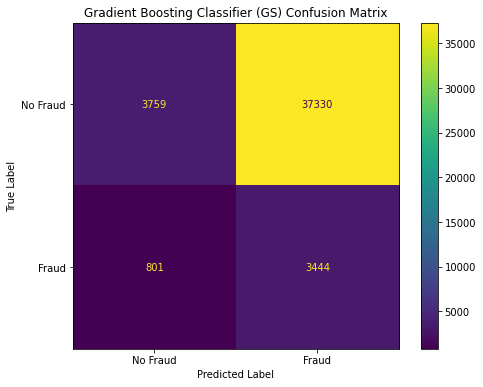

In [150]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_gsgbc)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title('Gradient Boosting Classifier (GS) Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot

plt.show()